# Genetic algorithm

Genetic algorithms (GAs) are a type of optimization and search algorithm inspired by the process of natural selection that Charles Darwin famously referred to as the "survival of the fittest." Developed by John Holland in the 1970s at the University of Michigan, they represent a fascinating intersection of computer science and biology, providing a computational analogue to biological evolution.

The fundamental concept behind genetic algorithms is the idea of evolution by the mechanism of selection, crossover (recombination), and mutation.

In [1]:
%run common.ipynb

In [2]:
import os
import csv
import time
import folium
import random
import pulp 
import itertools
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
from collections import deque
from tqdm import tqdm
from geopy.distance import geodesic
from typing import List, Dict, Tuple, Generator
from sklearn.cluster import KMeans

# Initial Values

In [3]:
city_count= 100 #Nombre de villes de l'algorithme
truck_number = 3 #Nombre de camions pour la version avec camions
start_time = 480 #Heure de départ en minutes

population_size = 300 #Taille de la population de l'algo gén
num_generations = 500 #Nombre de génération
children_size = 298 #Nombre d'enfants issus des parents précédents
mutation_rate = 99 #taux de mutation
tournament_size = 8 #Taille du pool de sélection de parents
elite_size = 1 #Nombre d'élites issues de la génération précédente en plus du premier
num_iteration = 30 #Nombre d'itérations du multistart
initial_random_seed = 3
max_threads = 20
dataset_file_path = os.path.join('../datasets', 'cities.csv')
measure_time.enabled = True

In [4]:
citiesTuple = read_csv_to_tuple(dataset_file_path)
citiesSample = sample_N_from_tuple(citiesTuple, city_count)

 the Function: read_csv_to_tuple took: 0.11310005187988281 seconds
 the Function: sample_N_from_tuple took: 0.011960506439208984 seconds


In [5]:
def reset_to_default_seed():
    random.seed(initial_random_seed)
    np.random.seed(initial_random_seed)

# time matrix generator

this part calculate a time matrix for a set of cities based on their geographic coordinates. 

In [6]:
reset_to_default_seed();

@measure_time
def calculate_distance_matrix(generator) -> Dict[str, Dict[str, float]]:
    distance_matrix = {}  # Create an empty dictionary to store the distance matrix
    city_coords = []  # Create an empty list to store city names and coordinates
    
    # Iterate over each city name and coordinates from the generator and 
    # append the city name and coordinates as a tuple to city_coords
    for city_name, coordinates in generator:
        city_coords.append((city_name, tuple([coordinates[1],coordinates[0],0]))) 
    # Iterate over the city name and coordinates using enumerate
    for i, (city1, coords1) in enumerate(city_coords):
        
        # Create an empty dictionary for each city in the distance matrix
        distance_matrix[city1] = {}
        
        # Iterate over the city name and coordinates again
        for j, (city2, coords2) in enumerate(city_coords):  
            if i == j:
                # Set the distance between a city and itself to 0.0
                distance_matrix[city1][city2] = 0.0 
            else:
                # Calculate the geodesic distance between two coordinates
                distance = geodesic(coords1, coords2).kilometers
                # Store the distance in the distance matrix
                distance_matrix[city1][city2] = distance / 51.3
    
    return distance_matrix

In [7]:
distance_matrix = calculate_distance_matrix(
    create_location_generator(citiesSample)
)

 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7496013641357422 seconds


# Distance matrix generator with frequency

The aim is to generate a distance matrix that takes frequentation into account. 
<br> So we'll present frequentation in the form of a table containing 4 values (travel times) indicated at different times of day (the two halves morning and afternoon).

In [8]:
@measure_time
def generate_distances_frequency(distances):
    distances_frequencies = {}

    for city_a, times in distances.items():
        distances_frequencies[city_a] = {}

        for city_b, time in times.items():
            if city_a == city_b:
                distances_frequencies[city_a][city_b] = [0 for i in range(4)]  # Assuming no traffic within the same city
            else:
                distances_frequencies[city_a][city_b] = [np.random.uniform(1.0, 1.5) * time for i in range(4)]
    
    return distances_frequencies

In [9]:
generator = create_location_generator(citiesSample)
generate_distances_frequency(calculate_distance_matrix(generator))

 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7458727359771729 seconds
 the Function: generate_distances_frequency took: 0.05202603340148926 seconds


{'La Chapelle-sous-Uchon': {'La Chapelle-sous-Uchon': [0, 0, 0, 0],
  'Chapet': [7.279678555025769,
   7.728736803591743,
   6.537973895399147,
   7.165608006214737],
  'Houtkerque': [13.140278183858394,
   13.155476920645373,
   9.65478549167386,
   10.025688647518336],
  'Pléboulle': [10.603726009336375,
   12.616179669515864,
   10.49212541072726,
   12.699002119165591],
  'Roussines': [7.8802504226555605,
   6.777679903162841,
   7.960895460347498,
   7.706884731455257],
  'Fleury': [8.381586345134693,
   10.596565448454843,
   9.355873994766839,
   10.001265026741935],
  'Saint-Hilaire-la-Treille': [5.211517651248335,
   6.1463462392308115,
   5.569664081302768,
   4.9224571169374265],
  'La Rouvière': [8.033505222680033,
   8.77750645496563,
   7.281233424118115,
   7.014763190779998],
  'Sermamagny': [5.062845159235096,
   6.225558913372524,
   6.309541612320591,
   5.66584070658513],
  'Bailleul-sur-Thérain': [9.06700472969595,
   8.888705191129016,
   7.427666347345669,
   6.5

# Initial solution generator

Since the most important part of a genetic algorithm is diversity, it is important to have varied but viable initial solutions.
We have therefore developed a random initial solution generator to generate several valid random graphs.

In [10]:
def generate_random_initial_solutions(distances,start_point):
    points = list(distances.keys())
    points.remove(start_point)
    remaining_points = points[:]
    path = [start_point]
    while remaining_points:
        next_point = np.random.choice(remaining_points)
        path.append(next_point)
        remaining_points.remove(next_point)
    return path

# Implementation of the Genetic algorithm with all constraints

This is our implementation of the genetic algorithm having all the constraints.

We have a first function split_into_trucks that takes a time matrix and the number of trucks as input. It converts the time matrix to a numpy array and performs k-means clustering to assign towns to different trucks based on their average travel times.

There are also a fitness function, ailung to to calculate the fitness of a tour (route), selection_tournament to select parents for the next generation based on tournament selection, crossover to perform crossover between two parent tours to create offspring, two_opt to perform a local search optimization called 2-opt, and mutate to introduce random mutations in a tour.

The main function genetic_algorithm implements the genetic algorithm itself. It initializes a population of random tours, performs parent selection using tournament selection, applies crossover and mutation to create offspring, replaces the population with the offspring, and repeats this process for a specified number of generations. The function keeps track of the best tour found so far and applies a 2-opt optimization to it after the generations are completed.

In the end, the function optimize_trucks takes the map, truck data, and other parameters as input. It iterates over each truck, applies the genetic algorithm to optimize its route, and visualizes the routes on the map.

In [11]:
def split_into_trucks(time_matrix, num_trucks):
    # Convert the time matrix to a numpy array
    towns = list(time_matrix.keys())
    time_array = np.array([[np.average(time_matrix[town1][town2]) for town2 in towns] for town1 in towns])
    
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_trucks, random_state=0, n_init=10).fit(time_array)
    labels = kmeans.labels_
    
    # Find the index of the first town in the time matrix
    first_town_index = towns.index(towns[0])
    
    
    # Create time matrices for each truck
    trucks = []
    for i in range(num_trucks):
        # Filter towns based on the label or if it's the first town
        truck_towns = [towns[j] for j in range(len(towns)) if labels[j] == i or j == first_town_index]
        truck_time_matrix = {town: {truck_town: time_matrix[town][truck_town] for truck_town in truck_towns} for town in truck_towns}
        trucks.append(truck_time_matrix)
    
    return trucks


def fitness(tour,distances,start_time):
    current_time= start_time
    current_distance = 0
    for x in range(len(tour)-1):
        if current_time > 1440:
            current_time-=1440
        current_distance += distances[tour[x]][tour[x+1]][current_time//360]
    return current_distance

# Sélection des parents par tournoi
def selection_tournament(population,distances,start_time,tournament_size):
    selected_parents = []
    for _ in range(len(population)):
        participants = random.sample(population, tournament_size)
        winner = min(participants, key=lambda k: fitness(k, distances,start_time))
        selected_parents.append(winner)
    return selected_parents

# Croisement
def crossover(parent1, parent2):
    div = 3
    offspring = [parent1[0]]  # Le premier élément de parent1 est ajouté à offspring
    c1_part1 = parent1[0:int((len(parent1)) / div)]
    c1_part2 = parent1[int((len(parent1)) / div):int(len(parent1) - int((len(parent1)) / div))]
    c1_part3 = parent1[int(len(parent1) - int((len(parent1)) / div)):]
    c2_part1 = parent2[0:int((len(parent2)) / div)]
    c2_part2 = parent2[int((len(parent2)) / div):int(len(parent2) - int((len(parent2)) / div))]
    c2_part3 = parent2[int(len(parent2) - int((len(parent2)) / div)):]
    
    for i in range(0, len(c2_part3)):
        if c2_part3[i] not in c1_part2:
            offspring.append(c2_part3[i])
    for i in range(0, len(c2_part1)):
        if c2_part1[i] not in c1_part2 and c2_part1[i] not in offspring:
            offspring.append(c2_part1[i])
    for i in range(0, len(c2_part2)):
        if c2_part2[i] not in c1_part2 and c2_part2[i] not in offspring:
            offspring.append(c2_part2[i])
    
    offspring.extend(c1_part2)
    
    for x in range(0, len(c1_part3)):
        if c1_part3[x] not in offspring:
            offspring.append(c1_part3[x])
            
    return offspring


# Opération 2-opt
def two_opt(tour,distances_freq,start_time):
    improved = True
    best_distance = fitness(tour,distances_freq,start_time)

    while improved:
        improved = False
        for i in range(1, len(tour) - 1):
            for j in range(i + 1, len(tour)):
                new_tour = tour[:i] + tour[i:j][::-1] + tour[j:]
                new_distance = fitness(new_tour,distances_freq,start_time)
                if new_distance < best_distance:
                    tour = new_tour
                    best_distance = new_distance
                    improved = True

    return tour

def mutate(tour,mutation_rate):
    p = random.randint(0, 100)
    if p < mutation_rate and (len(tour) - 1) > 1:
        gene1 = random.randint(1, len(tour)-2)
        gene2 = random.randint(1, len(tour)-2)
        tour[gene1], tour[gene2] = tour[gene2], tour[gene1]
    return tour;

def select_parents(population, distances_freq,starttime,tournament_size):
    fitness_sum = sum(fitness(individual,distances_freq,starttime) for individual in population)
    probabilities = [fitness(individual,distances_freq,starttime) / fitness_sum for individual in population]
    parents = random.choices(population, weights=probabilities, k=tournament_size)
    return parents

def fill_pop_with_random(population,range_for,start_point,distances):
    for i in range(range_for):
        population.append(generate_random_initial_solutions(distances, start_point))
    return population

def filter_cities_by_truck(citiesSample, truck):
    town_list = list(truck.keys())
    filtered_cities = [city for city in citiesSample if city[4] in town_list]
    return np.array(filtered_cities)

# Algorithme génétique
@measure_time
def genetic_algorithm(distances_freq,population_size,num_generations,mutation_rate,tournament_size,start_point,starttime,children_size,elite_size,show_progress=False):
    
    best_distance = 0  # O(1)
    optimum_count = 0   # O(1)
    
    if(show_progress):
        progress_bar = tqdm(
            total=num_generations, 
            desc="Genetic Algorithm", 
            unit="generation", 
        )
    # Initialisation de la population
    population = fill_pop_with_random([],population_size,start_point,distances_freq)  # O(n)
    for gen in range(num_generations):
        # Sélection des parents
        parents = selection_tournament(population,distances_freq,starttime,tournament_size)  # O(n*n)

        parents = sorted(parents, key=lambda k: fitness(k, distances_freq,starttime))  # O(n * log(n))
        
        #Ajout d'une élite à la population
        population = [parents[0]] + random.sample(parents[:tournament_size],elite_size)  # O(n)
        offspring = []
        for i in range(children_size):
            parent1, parent2 = random.choice(parents[:tournament_size]),parents[i]  # O(1)
            child = crossover(parent1, parent2)  # O(len(n))
            child = mutate(child,mutation_rate)  # O(len(n))
            offspring.append(child)  # O(1)
        # Remplacement de la population
        population = population + offspring
        population = fill_pop_with_random(population,population_size-len(population),start_point,distances_freq)
            
        currentwinner = min(population, key=lambda k: fitness(k, distances_freq,starttime))
        
        best_distance = fitness(currentwinner, distances_freq,starttime)
        #print("Current winner with : ",best_distance)
        #print("Current pop count : ",len(population))
        #print("Current generation : ",gen)
        #print("---------")
        if(show_progress):
            progress_bar.update(1)
        

    # Meilleure tournée après les générations
    best_tour = min(population, key=lambda k: fitness(k, distances_freq,starttime))  # O(n)
    best_tour.append(best_tour[0])  # O(1)
    
    #Optimisation finale
    best_tour = two_opt(best_tour,distances_freq,starttime)# O(n^2)
    
    # Évaluation de la meilleure tournée
    best_distance = fitness(best_tour,distances_freq,starttime)# O(len(n))


    return best_tour, best_distance

def optimize_trucks(map_obj,citiesSample,trucks,population_size,num_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size,show_progress=False, use_traffic_matrix=False):
    routes = []
    for i, truck in enumerate(trucks):
        if use_traffic_matrix:
            truck = generate_traffic_matrix(truck)
        best_route, best_time = genetic_algorithm(truck,population_size,num_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size)
        
        print(f"The truck n: {i} will do: {best_route} for a total of {best_time} h")
        plot_cities(filter_cities_by_truck(citiesSample, truck), best_route, map_obj=map_obj, color=color[i])
        routes.append([best_route, best_time])
    return map_obj, routes

In [12]:
map_center = [float(citiesSample[0][2]), float(citiesSample[0][3])]
map_obj = folium.Map(location=map_center, zoom_start=6)


generator = create_location_generator(citiesSample)
distances_km = calculate_distance_matrix(generator)
distances_freqU = generate_distances_frequency(distances_km)
trucks = split_into_trucks(distances_freqU,truck_number)

start_point = next(iter(distances_km.keys())) # this represent the first town found in the distances dict 
# this represent the first town found in the distances dict 

print(start_point)

map_obj,routes = optimize_trucks(map_obj,citiesSample,trucks,population_size,num_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size)

map_obj

 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7524847984313965 seconds
 the Function: generate_distances_frequency took: 0.0438532829284668 seconds
La Chapelle-sous-Uchon
 the Function: genetic_algorithm took: 5.03636908531189 seconds
The truck n: 0 will do: ['La Chapelle-sous-Uchon', 'Le Malzieu-Ville', 'Arlempdes', 'Saint-Étienne-du-Valdonnez', 'La Rouvière', 'Lagnes', 'Gargas', 'Vitrolles-en-Lubéron', 'Aups', 'Marie', 'Gincla', 'Esparron', 'Ambax', 'Marseillan', 'Arengosse', 'Gondrin', "Larroque-sur-l'Osse", 'Valence', 'Tanus', 'Arthès', 'Besse', 'Salles-de-Belvès', 'Nastringues', 'Le Fieu', 'Listrac-Médoc', 'Le Verdon-sur-Mer', 'Saint-Sauvant', 'Roussines', 'Saint-Hilaire-la-Treille', 'La Chapelle-sous-Uchon'] for a total of 57.285467081462485 h
 the Function: genetic_algorithm took: 7.670094728469849 seconds
The truck n: 1 will do: ['La Chapelle-sous-Uchon', 'Malay', 'Saunières', 'Denèvre', 'Frahier-et-Chatebier', 'Serm

# Pulp solver
In order to establish viable statistics, we had to write a pulp solver to obtain a true comparison of the algorithm's performance and the results obtained.

In [13]:
@measure_time
def solve_issue(trucks):
    max_value = 0
    # solve with pulp
    for initial_truck in trucks:
        truck = {}
        for element in initial_truck:
            truck[element] = {}
            for subelement in initial_truck[element]:
                truck[element][subelement] = np.round(initial_truck[element][subelement])
            
        # definition of LpProblem instance
        problem =pulp.LpProblem("CVRP", pulp.LpMinimize)

        truck_keys = list(truck.keys())
        
        # definition of variables 
        x = [[[pulp.LpVariable("x%s_%s"%(i,j), cat="Binary") if i != j else None] for j in truck_keys] for i in truck_keys]
        print(x)
        
        # add objective function
        problem += pulp.lpSum(np.min(truck[ikey][jkey]).astype(int) * x[iindex][jindex] if iindex != jindex else 0
                              for jindex,jkey in enumerate(truck_keys)
                              for iindex,ikey in enumerate(truck_keys))

        
        # constraints
        for j in range(1, len(truck)):
            problem += pulp.lpSum(x[iindex][j] if iindex != j else 0 
                                  for iindex,ikey in enumerate(truck_keys)) == 1 
        
        problem += pulp.lpSum(x[0][iindex] for iindex,ikey in enumerate(truck_keys)) == 1
        problem += pulp.lpSum(x[jindex][0] for jindex,jkey in enumerate(truck_keys)) == 1
        
        subtours = []

        
        problem.solve()
        print(pulp.value(problem.objective))
        if pulp.LpStatus[problem.status] == "Optimal":
            if(max_value < pulp.value(problem.objective)):
                max_value = pulp.value(problem.objective)
                print("NEW STRONK")
        else:
            raise Exception("No optimal solution found.")

    return max_value
        


In [14]:
generator = create_location_generator(citiesSample)
distances_km = calculate_distance_matrix(generator)
distances_freq = generate_distances_frequency(distances_km)
trucks = split_into_trucks(distances_freq,truck_number)

 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7524802684783936 seconds
 the Function: generate_distances_frequency took: 0.04285693168640137 seconds


In [15]:
solve_issue(trucks)

[[[None], [xLa_Chapelle_sous_Uchon_Roussines], [xLa_Chapelle_sous_Uchon_Saint_Hilaire_la_Treille], [xLa_Chapelle_sous_Uchon_La_Rouvière], [xLa_Chapelle_sous_Uchon_Gincla], [xLa_Chapelle_sous_Uchon_Valence], [xLa_Chapelle_sous_Uchon_Le_Malzieu_Ville], [xLa_Chapelle_sous_Uchon_Arlempdes], [xLa_Chapelle_sous_Uchon_Vitrolles_en_Lubéron], [xLa_Chapelle_sous_Uchon_Arengosse], [xLa_Chapelle_sous_Uchon_Lagnes], [xLa_Chapelle_sous_Uchon_Marie], [xLa_Chapelle_sous_Uchon_Esparron], [xLa_Chapelle_sous_Uchon_Gondrin], [xLa_Chapelle_sous_Uchon_Larroque_sur_l'Osse], [xLa_Chapelle_sous_Uchon_Salles_de_Belvès], [xLa_Chapelle_sous_Uchon_Nastringues], [xLa_Chapelle_sous_Uchon_Le_Fieu], [xLa_Chapelle_sous_Uchon_Le_Verdon_sur_Mer], [xLa_Chapelle_sous_Uchon_Listrac_Médoc], [xLa_Chapelle_sous_Uchon_Saint_Étienne_du_Valdonnez], [xLa_Chapelle_sous_Uchon_Arthès], [xLa_Chapelle_sous_Uchon_Ambax], [xLa_Chapelle_sous_Uchon_Tanus], [xLa_Chapelle_sous_Uchon_Gargas], [xLa_Chapelle_sous_Uchon_Aups], [xLa_Chapelle_sous

37.0

# Multistart implementation
Still with the aim of obtaining good statistics, we had to implement a multistart function that would launch several instances of problem solving in order to find an optimal solution across several genetic environments.
We used the notion of multithreading to improve the overall performances.

In [16]:
def multistart(max_threads,num_iteration,citiesSample,trucks,population_size,num_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size,show_progress=False):
    paths_and_maps = []
    
    def launchGenetic(citiesSample,trucks,population_size,num_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size,show_progress=False):
        map_center = [float(citiesSample[0][2]), float(citiesSample[0][3])]
        map_obj = folium.Map(location=map_center, zoom_start=6)
        map_obj, paths = optimize_trucks(map_obj,citiesSample,trucks,population_size,num_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size,show_progress)
        second_column = [sublist[1] for sublist in paths]
        max_value = np.max(np.array(second_column))
        current_path_distance = max_value
        paths_and_maps.append([map_obj,current_path_distance])
            
            
            
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = [executor.submit(launchGenetic, citiesSample,trucks,population_size,num_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size,show_progress) for i in range(num_iteration)]
        concurrent.futures.wait(futures)
                
    
    return paths_and_maps

In [17]:
map_center = [float(citiesSample[0][2]), float(citiesSample[0][3])]
map_obj = folium.Map(location=map_center, zoom_start=6)

generator = create_location_generator(citiesSample)
distances_km = calculate_distance_matrix(generator)
distances_freq = generate_distances_frequency(distances_km)
trucks = split_into_trucks(distances_freq,truck_number)

start_point = next(iter(distances_km.keys())) # this represent the first town found in the distances dict 
# this represent the first town found in the distances dict 

print(start_point)

paths_and_maps = multistart(max_threads,num_iteration,citiesSample,trucks,population_size,num_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size)


 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7409477233886719 seconds
 the Function: generate_distances_frequency took: 0.041860103607177734 seconds
La Chapelle-sous-Uchon
 the Function: genetic_algorithm took: 10.786655187606812 seconds
The truck n: 0 will do: ['La Chapelle-sous-Uchon', 'Orville', 'Marbéville', 'Combles-en-Barrois', 'Villotte-devant-Louppy', 'Les Souhesmes-Rampont', 'Grandpré', 'Landres', 'Trémery', 'Rosières-sur-Mance', 'Cuzieu', 'Grézieu-le-Marché', 'Saint-Genès-du-Retz', 'Sanssat', 'Boucé', 'Neuilly-en-Dun', 'Oizon', 'Saint-Vérain', 'Biches', 'Écutigny', 'Saunières', 'Ounans', 'Cramans', 'Denèvre', 'Vouxey', 'Chalaines', 'Rigny-Saint-Martin', 'Marthille', 'Hertzing', 'Flainval', 'Domptail', 'Dogneville', 'Dierrey-Saint-Pierre', 'Beaumont-du-Gâtinais', 'Neuillay-les-Bois', 'Vallon-en-Sully', 'Motey-Besuche', 'Valay', 'Tallans', 'Sermamagny', 'Frahier-et-Chatebier', 'Anteuil', 'Malay', 'La Chapelle-sous-U

 the Function: genetic_algorithm took: 118.58043384552002 seconds
The truck n: 0 will do: ['La Chapelle-sous-Uchon', 'Biches', 'Neuilly-en-Dun', 'Oizon', 'Saint-Vérain', 'Écutigny', 'Saunières', 'Malay', 'Grézieu-le-Marché', 'Cuzieu', 'Cramans', 'Ounans', 'Motey-Besuche', 'Valay', 'Rosières-sur-Mance', 'Orville', 'Denèvre', 'Tallans', 'Anteuil', 'Frahier-et-Chatebier', 'Sermamagny', 'Dogneville', 'Domptail', 'Flainval', 'Hertzing', 'Marthille', 'Trémery', 'Landres', 'Les Souhesmes-Rampont', 'Grandpré', 'Villotte-devant-Louppy', 'Combles-en-Barrois', 'Rigny-Saint-Martin', 'Chalaines', 'Vouxey', 'Marbéville', 'Dierrey-Saint-Pierre', 'Beaumont-du-Gâtinais', 'Neuillay-les-Bois', 'Vallon-en-Sully', 'Saint-Genès-du-Retz', 'Boucé', 'Sanssat', 'La Chapelle-sous-Uchon'] for a total of 53.57080647891418 h
 the Function: genetic_algorithm took: 119.57922410964966 seconds
The truck n: 0 will do: ['La Chapelle-sous-Uchon', 'Biches', 'Sanssat', 'Boucé', 'Saint-Genès-du-Retz', 'Grézieu-le-Marché', 'C

 the Function: genetic_algorithm took: 137.6977379322052 seconds
The truck n: 1 will do: ['La Chapelle-sous-Uchon', 'Saint-Hilaire-la-Treille', 'Roussines', 'Saint-Sauvant', 'Le Verdon-sur-Mer', 'Listrac-Médoc', 'Le Fieu', 'Nastringues', 'Salles-de-Belvès', 'Besse', 'Valence', 'Arengosse', "Larroque-sur-l'Osse", 'Gondrin', 'Marseillan', 'Esparron', 'Ambax', 'Gincla', 'Arthès', 'Tanus', 'La Rouvière', 'Vitrolles-en-Lubéron', 'Marie', 'Aups', 'Gargas', 'Lagnes', 'Saint-Étienne-du-Valdonnez', 'Arlempdes', 'Le Malzieu-Ville', 'La Chapelle-sous-Uchon'] for a total of 55.281924561454716 h
 the Function: genetic_algorithm took: 140.64423727989197 seconds
The truck n: 1 will do: ['La Chapelle-sous-Uchon', 'Aups', 'Gargas', 'Lagnes', 'La Rouvière', 'Gincla', 'Ambax', 'Esparron', 'Marseillan', 'Gondrin', "Larroque-sur-l'Osse", 'Salles-de-Belvès', 'Besse', 'Saint-Hilaire-la-Treille', 'Roussines', 'Saint-Sauvant', 'Le Verdon-sur-Mer', 'Listrac-Médoc', 'Le Fieu', 'Nastringues', 'Arengosse', 'Valenc

 the Function: genetic_algorithm took: 102.58161902427673 seconds
The truck n: 1 will do: ['La Chapelle-sous-Uchon', 'Saint-Hilaire-la-Treille', 'Roussines', 'Saint-Sauvant', 'Le Verdon-sur-Mer', 'Listrac-Médoc', 'Le Fieu', 'Nastringues', "Larroque-sur-l'Osse", 'Gondrin', 'Arengosse', 'Marseillan', 'Esparron', 'Ambax', 'Valence', 'Besse', 'Salles-de-Belvès', 'Tanus', 'Arthès', 'Gincla', 'Lagnes', 'Vitrolles-en-Lubéron', 'Marie', 'Aups', 'Gargas', 'La Rouvière', 'Saint-Étienne-du-Valdonnez', 'Arlempdes', 'Le Malzieu-Ville', 'La Chapelle-sous-Uchon'] for a total of 57.26466814071719 h
 the Function: genetic_algorithm took: 100.20794939994812 seconds
The truck n: 1 will do: ['La Chapelle-sous-Uchon', 'Le Malzieu-Ville', 'Arlempdes', 'Saint-Étienne-du-Valdonnez', 'Vitrolles-en-Lubéron', 'Marie', 'Aups', 'Gargas', 'Lagnes', 'La Rouvière', 'Gincla', 'Ambax', 'Esparron', 'Marseillan', 'Gondrin', 'Arengosse', 'Listrac-Médoc', 'Le Verdon-sur-Mer', 'Saint-Sauvant', 'Saint-Hilaire-la-Treille', 'R

 the Function: genetic_algorithm took: 99.14890432357788 seconds
The truck n: 2 will do: ['La Chapelle-sous-Uchon', 'Seringes-et-Nesles', 'Ocquerre', 'Lognes', 'Champenard', 'Piseux', 'Tellières-le-Plessis', 'Renac', 'Mordelles', 'Guimiliau', 'Pléboulle', 'Surtainville', 'Percy-en-Normandie', 'Saint-Roch-sur-Égrenne', 'Épinay-sur-Odon', 'Roiville', 'Saint-Vincent-du-Boulay', 'Blangy-le-Château', 'Flamets-Frétils', 'Houtkerque', 'Bayenghem-lès-Éperlecques', 'Bécourt', 'Fleury', 'Wavrans-sur-Ternoise', 'Bailleul-sur-Thérain', 'Chapet', 'Le Perchay', 'Dancourt-Popincourt', 'Sinceny', 'Fourdrain', 'La Chapelle-sous-Uchon'] for a total of 55.88938243624664 h
 the Function: genetic_algorithm took: 101.89503049850464 seconds
The truck n: 2 will do: ['La Chapelle-sous-Uchon', 'Lognes', 'Ocquerre', 'Chapet', 'Le Perchay', 'Champenard', 'Piseux', 'Tellières-le-Plessis', 'Renac', 'Mordelles', 'Guimiliau', 'Pléboulle', 'Surtainville', 'Épinay-sur-Odon', 'Percy-en-Normandie', 'Saint-Roch-sur-Égrenn

 the Function: genetic_algorithm took: 115.19571495056152 seconds
The truck n: 0 will do: ['La Chapelle-sous-Uchon', 'Biches', 'Saint-Vérain', 'Neuilly-en-Dun', 'Neuillay-les-Bois', 'Vallon-en-Sully', 'Saint-Genès-du-Retz', 'Sanssat', 'Boucé', 'Grézieu-le-Marché', 'Cuzieu', 'Malay', 'Écutigny', 'Saunières', 'Ounans', 'Cramans', 'Motey-Besuche', 'Valay', 'Tallans', 'Anteuil', 'Frahier-et-Chatebier', 'Sermamagny', 'Dogneville', 'Vouxey', 'Chalaines', 'Rigny-Saint-Martin', 'Flainval', 'Domptail', 'Hertzing', 'Marthille', 'Trémery', 'Landres', 'Les Souhesmes-Rampont', 'Grandpré', 'Villotte-devant-Louppy', 'Combles-en-Barrois', 'Marbéville', 'Orville', 'Denèvre', 'Rosières-sur-Mance', 'Dierrey-Saint-Pierre', 'Beaumont-du-Gâtinais', 'Oizon', 'La Chapelle-sous-Uchon'] for a total of 54.43382647835511 h
 the Function: genetic_algorithm took: 133.51676440238953 seconds
The truck n: 0 will do: ['La Chapelle-sous-Uchon', 'Biches', 'Malay', 'Cuzieu', 'Grézieu-le-Marché', 'Boucé', 'Sanssat', 'Saint

 the Function: genetic_algorithm took: 43.856788635253906 seconds
The truck n: 1 will do: ['La Chapelle-sous-Uchon', 'Le Malzieu-Ville', 'Arlempdes', 'Saint-Étienne-du-Valdonnez', 'La Rouvière', 'Lagnes', 'Gargas', 'Vitrolles-en-Lubéron', 'Marie', 'Aups', 'Tanus', 'Arthès', 'Gincla', 'Ambax', 'Esparron', 'Marseillan', 'Arengosse', 'Gondrin', "Larroque-sur-l'Osse", 'Valence', 'Besse', 'Salles-de-Belvès', 'Nastringues', 'Le Fieu', 'Listrac-Médoc', 'Le Verdon-sur-Mer', 'Saint-Sauvant', 'Roussines', 'Saint-Hilaire-la-Treille', 'La Chapelle-sous-Uchon'] for a total of 54.760301458549925 h
 the Function: genetic_algorithm took: 43.909552335739136 seconds
The truck n: 1 will do: ['La Chapelle-sous-Uchon', 'Le Fieu', 'Arengosse', 'Marseillan', 'Gondrin', "Larroque-sur-l'Osse", 'Salles-de-Belvès', 'Besse', 'Saint-Hilaire-la-Treille', 'Roussines', 'Saint-Sauvant', 'Le Verdon-sur-Mer', 'Listrac-Médoc', 'Nastringues', 'Valence', 'Ambax', 'Esparron', 'Gincla', 'Arthès', 'Tanus', 'La Rouvière', 'Vit

 the Function: genetic_algorithm took: 56.07692193984985 seconds
The truck n: 2 will do: ['La Chapelle-sous-Uchon', 'Le Perchay', 'Chapet', 'Bailleul-sur-Thérain', 'Lognes', 'Ocquerre', 'Seringes-et-Nesles', 'Sinceny', 'Fourdrain', 'Dancourt-Popincourt', 'Wavrans-sur-Ternoise', 'Fleury', 'Bécourt', 'Bayenghem-lès-Éperlecques', 'Houtkerque', 'Flamets-Frétils', 'Blangy-le-Château', 'Saint-Vincent-du-Boulay', 'Épinay-sur-Odon', 'Percy-en-Normandie', 'Surtainville', 'Guimiliau', 'Pléboulle', 'Renac', 'Mordelles', 'Saint-Roch-sur-Égrenne', 'Roiville', 'Tellières-le-Plessis', 'Champenard', 'Piseux', 'La Chapelle-sous-Uchon'] for a total of 54.57823608352336 h
 the Function: genetic_algorithm took: 53.7801308631897 seconds
The truck n: 2 will do: ['La Chapelle-sous-Uchon', 'Seringes-et-Nesles', 'Sinceny', 'Fourdrain', 'Dancourt-Popincourt', 'Wavrans-sur-Ternoise', 'Fleury', 'Bécourt', 'Bayenghem-lès-Éperlecques', 'Houtkerque', 'Flamets-Frétils', 'Bailleul-sur-Thérain', 'Piseux', 'Tellières-le

In [18]:
pathT = None
mapT = None 
sorted_list = sorted(paths_and_maps, key=lambda x: x[1])
pathT, mapT = sorted_list[0][1],sorted_list[0][0]

print("With a maximum individual path size of :",pathT)
mapT

With a maximum individual path size of : 55.281924561454716


In [19]:
solve_issue(trucks)

[[[None], [xLa_Chapelle_sous_Uchon_Sermamagny], [xLa_Chapelle_sous_Uchon_Tallans], [xLa_Chapelle_sous_Uchon_Denèvre], [xLa_Chapelle_sous_Uchon_Frahier_et_Chatebier], [xLa_Chapelle_sous_Uchon_Villotte_devant_Louppy], [xLa_Chapelle_sous_Uchon_Vouxey], [xLa_Chapelle_sous_Uchon_Sanssat], [xLa_Chapelle_sous_Uchon_Combles_en_Barrois], [xLa_Chapelle_sous_Uchon_Hertzing], [xLa_Chapelle_sous_Uchon_Ounans], [xLa_Chapelle_sous_Uchon_Valay], [xLa_Chapelle_sous_Uchon_Neuillay_les_Bois], [xLa_Chapelle_sous_Uchon_Grandpré], [xLa_Chapelle_sous_Uchon_Beaumont_du_Gâtinais], [xLa_Chapelle_sous_Uchon_Marthille], [xLa_Chapelle_sous_Uchon_Flainval], [xLa_Chapelle_sous_Uchon_Dierrey_Saint_Pierre], [xLa_Chapelle_sous_Uchon_Landres], [xLa_Chapelle_sous_Uchon_Marbéville], [xLa_Chapelle_sous_Uchon_Neuilly_en_Dun], [xLa_Chapelle_sous_Uchon_Les_Souhesmes_Rampont], [xLa_Chapelle_sous_Uchon_Rosières_sur_Mance], [xLa_Chapelle_sous_Uchon_Biches], [xLa_Chapelle_sous_Uchon_Dogneville], [xLa_Chapelle_sous_Uchon_Cuzieu], 

33.0
NEW STRONK
[[[None], [xLa_Chapelle_sous_Uchon_Roussines], [xLa_Chapelle_sous_Uchon_Saint_Hilaire_la_Treille], [xLa_Chapelle_sous_Uchon_La_Rouvière], [xLa_Chapelle_sous_Uchon_Gincla], [xLa_Chapelle_sous_Uchon_Valence], [xLa_Chapelle_sous_Uchon_Le_Malzieu_Ville], [xLa_Chapelle_sous_Uchon_Arlempdes], [xLa_Chapelle_sous_Uchon_Vitrolles_en_Lubéron], [xLa_Chapelle_sous_Uchon_Arengosse], [xLa_Chapelle_sous_Uchon_Lagnes], [xLa_Chapelle_sous_Uchon_Marie], [xLa_Chapelle_sous_Uchon_Esparron], [xLa_Chapelle_sous_Uchon_Gondrin], [xLa_Chapelle_sous_Uchon_Larroque_sur_l'Osse], [xLa_Chapelle_sous_Uchon_Salles_de_Belvès], [xLa_Chapelle_sous_Uchon_Nastringues], [xLa_Chapelle_sous_Uchon_Le_Fieu], [xLa_Chapelle_sous_Uchon_Le_Verdon_sur_Mer], [xLa_Chapelle_sous_Uchon_Listrac_Médoc], [xLa_Chapelle_sous_Uchon_Saint_Étienne_du_Valdonnez], [xLa_Chapelle_sous_Uchon_Arthès], [xLa_Chapelle_sous_Uchon_Ambax], [xLa_Chapelle_sous_Uchon_Tanus], [xLa_Chapelle_sous_Uchon_Gargas], [xLa_Chapelle_sous_Uchon_Aups], [x

32.0
 the Function: solve_issue took: 0.25115966796875 seconds


33.0

# Population impact on results

In [51]:
bornes = deque(())

nb_tests = 400
wanted_generations = 300
jump_size = 10

bar = IntProgress(min=0, max=400, layout={"width" : "100%"})
display(bar)
generator = create_location_generator(citiesSample)
distances_km = calculate_distance_matrix(generator)
distances_freq = generate_distances_frequency(distances_km)
trucks = split_into_trucks(distances_freq,truck_number)

distances_list = deque(())
best_distances = deque(())
borne = solve_issue(trucks)
    
for wanted_population in range(10,nb_tests,jump_size):
    generator = create_location_generator(citiesSample)
    distances_km = calculate_distance_matrix(generator)
    distances_freq = generate_distances_frequency(distances_km)
    trucks = split_into_trucks(distances_freq,truck_number)
    start_point = next(iter(distances_km.keys()))
    
    paths_and_maps = multistart(max_threads,6,citiesSample,trucks,wanted_population,wanted_generations,mutation_rate,tournament_size,start_point,start_time,wanted_population-1,0)
    
    pathT = None
    mapT = None 
    sorted_list = sorted(paths_and_maps, key=lambda x: x[1])
    
    pathT, mapT = sorted_list[0][1],sorted_list[0][0]
    val = pathT
    best_distance_of_gen = val*100/borne      
    distances_list.append(best_distance_of_gen)    
    if len(best_distances) == 0 or best_distances[-1] > best_distance_of_gen:
        best_distances.append(best_distance_of_gen)
    else:
        best_distances.append(best_distances[-1])
                              
    bar.value += jump_size                                      

bar.close()

IntProgress(value=0, layout=Layout(width='100%'), max=400)

 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7877242565155029 seconds
 the Function: generate_distances_frequency took: 0.05152750015258789 seconds
[[[None], [xBeaufort_en_Santerre_Lamarche_sur_Saône], [xBeaufort_en_Santerre_La_Loge_aux_Chèvres], [xBeaufort_en_Santerre_Châtillon_sous_les_Côtes], [xBeaufort_en_Santerre_Saint_Marcel], [xBeaufort_en_Santerre_Saint_Rémy], [xBeaufort_en_Santerre_Gélaucourt], [xBeaufort_en_Santerre_Laignes], [xBeaufort_en_Santerre_Lindre_Basse], [xBeaufort_en_Santerre_Vix], [xBeaufort_en_Santerre_Hatrize], [xBeaufort_en_Santerre_Saint_Thomas_en_Argonne], [xBeaufort_en_Santerre_Les_Vigneaux], [xBeaufort_en_Santerre_Nozières], [xBeaufort_en_Santerre_Trouvans], [xBeaufort_en_Santerre_Retschwiller], [xBeaufort_en_Santerre_Cirey_lès_Pontailler], [xBeaufort_en_Santerre_Sainte_Agnès], [xBeaufort_en_Santerre_Essert_Romand], [xBeaufort_en_Santerre_Charpentry], [xBeaufort_en_Santerre_Fleurey_sur_Ouche], [x

49.0
NEW STRONK
[[[None], [xBeaufort_en_Santerre_Dives_sur_Mer], [xBeaufort_en_Santerre_Loffre], [xBeaufort_en_Santerre_Saint_Brice_de_Landelles], [xBeaufort_en_Santerre_Mentque_Nortbécourt], [xBeaufort_en_Santerre_Colleville_sur_Mer], [xBeaufort_en_Santerre_Longueval], [xBeaufort_en_Santerre_Callengeville], [xBeaufort_en_Santerre_Cherbourg_en_Cotentin], [xBeaufort_en_Santerre_Médan], [xBeaufort_en_Santerre_Saint_Ouen_sur_Iton], [xBeaufort_en_Santerre_Forges_les_Eaux], [xBeaufort_en_Santerre_Bohal], [xBeaufort_en_Santerre_Eaucourt_sur_Somme], [xBeaufort_en_Santerre_Mercey], [xBeaufort_en_Santerre_Livet], [xBeaufort_en_Santerre_Béhéricourt], [xBeaufort_en_Santerre_Rouvres_Saint_Jean], [xBeaufort_en_Santerre_Plessé], [xBeaufort_en_Santerre_Vitry_sur_Seine], [xBeaufort_en_Santerre_Houdan], [xBeaufort_en_Santerre_Robecq], [xBeaufort_en_Santerre_Feings], [xBeaufort_en_Santerre_Saint_Rimay], [xBeaufort_en_Santerre_Vineuil_Saint_Firmin], [xBeaufort_en_Santerre_Barville], [xBeaufort_en_Santerr

 the Function: calculate_distance_matrix took: 0.7605323791503906 seconds
 the Function: generate_distances_frequency took: 0.04151034355163574 seconds
 the Function: genetic_algorithm took: 0.21575284004211426 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'La Loge-aux-Chèvres', 'Tantonville', 'Vescheim', 'Gélaucourt', 'Longchamp-sous-Châtenois', 'Vix', 'Laignes', 'Saint-Rémy', 'Diennes-Aubigny', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Chassy', 'Ramasse', 'Ambilly', 'Boëge', 'Essert-Romand', 'Les Vigneaux', 'Murinais', 'Sainte-Agnès', 'Saint-Genix-sur-Guiers', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Baulay', 'Trouvans', 'Attenschwiller', 'Biederthal', 'Retschwiller', 'Lindre-Basse', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Saint-Aubin-sur-Aire', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 65.4087963637706 h
 the Function: genetic_algorithm took: 0.2350163459777832 seconds
The tru

 the Function: genetic_algorithm took: 0.7582321166992188 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Villefollet', 'Mouleydier', 'Saint-Front-sur-Lémance', "Saint-André-d'Allas", 'Curemonte', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Le Soler', 'Fontanès-de-Sault', 'Peyrefitte-du-Razès', 'Villegly', 'Lamontélarié', 'Navès', 'Fiac', 'Fénols', 'Lisle-sur-Tarn', 'Miradoux', 'Benque-Dessous-et-Dessus', 'Uzos', 'Bussunarits-Sarrasquette', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Le Brouilh-Monbert', 'Pessac-sur-Dordogne', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Moëze', 'La Jarne', 'Saint-Révérend', 'Beaufort-en-Santerre'] for a total of 72.95427630645027 h
 the Function: genetic_algorithm took: 0.7468736171722412 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", "Grenade-sur-l'Adour", 'Bussunarits-Sarrasquette', 'Uzos', '

 the Function: genetic_algorithm took: 1.640963077545166 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Marcenat', 'Mazerier', 'Barrais-Bussolles', 'Chassy', 'Ramasse', 'Saint-Genix-sur-Guiers', 'Murinais', 'Sainte-Agnès', 'Les Vigneaux', 'Ambilly', 'Essert-Romand', 'Boëge', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'Vix', 'La Loge-aux-Chèvres', 'Laignes', 'Saint-Rémy', 'Trouvans', 'Attenschwiller', 'Biederthal', 'Baulay', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Vescheim', 'Retschwiller', 'Lindre-Basse', 'Saint-Aubin-sur-Aire', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 61.69604735148382 h
 the Function: genetic_algorithm took: 1.5958263874053955 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Médan', 'Houdan', 'Émancé', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 

 the Function: calculate_distance_matrix took: 0.7485899925231934 seconds
 the Function: generate_distances_frequency took: 0.03775477409362793 seconds
 the Function: genetic_algorithm took: 0.6556410789489746 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Laignes', 'Vix', 'La Loge-aux-Chèvres', 'Saint-Aubin-sur-Aire', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Retschwiller', 'Vescheim', 'Lindre-Basse', 'Tantonville', 'Gélaucourt', 'Longchamp-sous-Châtenois', 'Baulay', 'Trouvans', 'Biederthal', 'Attenschwiller', 'Essert-Romand', 'Ambilly', 'Boëge', 'Les Vigneaux', 'Sainte-Agnès', 'Murinais', 'Saint-Genix-sur-Guiers', 'Ramasse', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'Saint-Rémy', 'Diennes-Aubigny', 'Chassy', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Nozières', 'Saint-Marcel', 'Beaufort-en-Santerre'] for a total of 60.55694684865995 h
 the Function: genetic_algorithm took: 0.7759838104248047 seconds
The tru

 the Function: genetic_algorithm took: 1.8868813514709473 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Béhéricourt', 'Prémont', 'Loffre', 'Robecq', 'Mentque-Nortbécourt', 'Nieurlet', 'Longueval', 'Eaucourt-sur-Somme', 'Callengeville', 'Forges-les-Eaux', 'Goupillières', 'Barville', 'Dives-sur-Mer', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Saint-Brice-de-Landelles', 'Plessé', 'Bohal', 'Livet', 'Saint-Rimay', 'Feings', 'Saint-Ouen-sur-Iton', 'Mercey', 'Houdan', 'Émancé', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Vitry-sur-Seine', 'Médan', 'Vineuil-Saint-Firmin', 'Beaufort-en-Santerre'] for a total of 41.545151078842096 h
 the Function: genetic_algorithm took: 1.6140093803405762 seconds the Function: genetic_algorithm took: 2.408503532409668 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Lamontélarié', 'Fénols', 'Navès', 'Villegly', 'Le Soler', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Benque-Dessous-et-Dessus

 the Function: genetic_algorithm took: 3.0369157791137695 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'La Loge-aux-Chèvres', 'Baulay', 'Trouvans', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'Laignes', 'Vix', 'Saint-Rémy', 'Diennes-Aubigny', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Chassy', 'Ramasse', 'Saint-Genix-sur-Guiers', 'Murinais', 'Sainte-Agnès', 'Les Vigneaux', 'Boëge', 'Ambilly', 'Essert-Romand', 'Biederthal', 'Attenschwiller', 'Retschwiller', 'Vescheim', 'Lindre-Basse', 'Tantonville', 'Gélaucourt', 'Longchamp-sous-Châtenois', 'Saint-Aubin-sur-Aire', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 56.451310986302865 h
 the Function: genetic_algorithm took: 3.3476645946502686 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'La Loge-aux-Chèvres', 'Laignes', 'Vix', 'Saint-Rémy', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey

 the Function: calculate_distance_matrix took: 0.825822114944458 seconds
 the Function: generate_distances_frequency took: 0.04584646224975586 seconds
 the Function: genetic_algorithm took: 0.8268346786499023 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Aubin-sur-Aire', 'Baulay', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Trouvans', 'Biederthal', 'Attenschwiller', 'Essert-Romand', 'Boëge', 'Ambilly', 'Saint-Genix-sur-Guiers', 'Les Vigneaux', 'Sainte-Agnès', 'Murinais', 'Ramasse', 'Chassy', 'Diennes-Aubigny', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Fleurey-sur-Ouche', 'Saint-Rémy', 'Laignes', 'Vix', 'La Loge-aux-Chèvres', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 61.76058209620164 h
 the Function: genetic_algorithm took: 1.5049128532409668 seconds
The truc

 the Function: genetic_algorithm took: 3.655606269836426 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Villefollet', 'Triac-Lautrait', 'Miradoux', 'Saint-Front-sur-Lémance', "Saint-André-d'Allas", 'Curemonte', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Lamontélarié', 'Fénols', 'Lisle-sur-Tarn', 'Fiac', 'Navès', 'Villegly', 'Le Soler', 'Fontanès-de-Sault', 'Peyrefitte-du-Razès', 'Benque-Dessous-et-Dessus', 'Bussunarits-Sarrasquette', 'Uzos', 'Mascaraàs-Haron', 'Le Brouilh-Monbert', "Grenade-sur-l'Adour", 'Pessac-sur-Dordogne', 'Mouleydier', "Fontaines-d'Ozillac", 'Moëze', 'La Jarne', 'Saint-Révérend', 'Beaufort-en-Santerre'] for a total of 73.18569495541013 h
 the Function: genetic_algorithm took: 3.6129794120788574 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Eaucourt-sur-Somme', 'Forges-les-Eaux', 'Goupillières', 'Barville', 'Dives-sur-Mer', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Saint-Brice-de-Landell

 the Function: genetic_algorithm took: 4.991031646728516 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Murinais', 'Saint-Genix-sur-Guiers', 'Sainte-Agnès', 'Les Vigneaux', 'Essert-Romand', 'Boëge', 'Ambilly', 'Ramasse', 'Diennes-Aubigny', 'Barrais-Bussolles', 'Chassy', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'Baulay', 'Trouvans', 'Biederthal', 'Attenschwiller', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Saint-Aubin-sur-Aire', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 62.712348018216254 h
 the Function: genetic_algorithm took: 4.590768098831177 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Pessac-sur-Dord

 the Function: calculate_distance_matrix took: 0.7553460597991943 seconds
 the Function: generate_distances_frequency took: 0.031249046325683594 seconds
 the Function: genetic_algorithm took: 1.7242772579193115 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Diennes-Aubigny', 'Chassy', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Ramasse', 'Saint-Genix-sur-Guiers', 'Murinais', 'Sainte-Agnès', 'Les Vigneaux', 'Essert-Romand', 'Boëge', 'Ambilly', 'Trouvans', 'Attenschwiller', 'Biederthal', 'Baulay', 'Longchamp-sous-Châtenois', 'Saint-Aubin-sur-Aire', 'Gélaucourt', 'Tantonville', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 59.42166644854588 h
 the Function: genetic_algorithm took: 1.8930308818817139 seconds
The tr

 the Function: genetic_algorithm took: 4.83878231048584 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Forges-les-Eaux', 'Mercey', 'Médan', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Émancé', 'Houdan', 'Saint-Ouen-sur-Iton', 'Feings', 'Saint-Rimay', 'Livet', 'Saint-Brice-de-Landelles', 'Plessé', 'Bohal', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer', 'Dives-sur-Mer', 'Barville', 'Goupillières', 'Callengeville', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Longueval', 'Loffre', 'Prémont', 'Béhéricourt', 'Beaufort-en-Santerre'] for a total of 43.24267247620215 h
 the Function: genetic_algorithm took: 4.019923448562622 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Longueval', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Émancé', 'Médan', 'Forges-les-Eaux', 'Barville

 the Function: genetic_algorithm took: 6.360870122909546 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Triac-Lautrait', 'Villefollet', 'Moëze', 'La Jarne', 'Saint-Révérend', "Fontaines-d'Ozillac", 'Pessac-sur-Dordogne', 'Mouleydier', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Miradoux', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Benque-Dessous-et-Dessus', 'Bussunarits-Sarrasquette', 'Uzos', 'Le Brouilh-Monbert', 'Lisle-sur-Tarn', 'Fénols', 'Fiac', 'Navès', 'Lamontélarié', 'Villegly', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'La Chapelle-Laurent', 'Velzic', 'Jussac', 'Curemonte', 'Beaufort-en-Santerre'] for a total of 72.42277708197308 h
 the Function: genetic_algorithm took: 6.225514888763428 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Velzic', 'Jussac', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Lamontélarié', 'Benque-Dessous-et-Dessus', 'Bussunarits-Sarrasqu

 the Function: calculate_distance_matrix took: 0.7665817737579346 seconds
 the Function: generate_distances_frequency took: 0.04136323928833008 seconds
 the Function: genetic_algorithm took: 1.3788650035858154 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Saint-Aubin-sur-Aire', 'Tantonville', 'Gélaucourt', 'Vescheim', 'Retschwiller', 'Lindre-Basse', 'Attenschwiller', 'Biederthal', 'Essert-Romand', 'Boëge', 'Ambilly', 'Ramasse', 'Saint-Genix-sur-Guiers', 'Sainte-Agnès', 'Les Vigneaux', 'Murinais', 'Marcenat', 'Mazerier', 'Barrais-Bussolles', 'Chassy', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Trouvans', 'Baulay', 'Longchamp-sous-Châtenois', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Fleurey-sur-Ouche', 'Diennes-Aubigny', 'Nozières', 'Saint-Marcel', 'Beaufort-en-Santerre'] for a total of 64.95757367307279 h
 the Function: genetic_algorithm took: 2.583747148513794 seconds
The truc

 the Function: genetic_algorithm took: 6.219680070877075 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Curemonte', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Mouleydier', 'Pessac-sur-Dordogne', "Grenade-sur-l'Adour", 'Bussunarits-Sarrasquette', 'Uzos', 'Mascaraàs-Haron', 'Miradoux', 'Le Brouilh-Monbert', 'Benque-Dessous-et-Dessus', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Villegly', 'Navès', 'Fiac', 'Lisle-sur-Tarn', 'Fénols', 'Lamontélarié', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'Beaufort-en-Santerre'] for a total of 73.37948974244941 h
 the Function: genetic_algorithm took: 6.094854354858398 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Longueval', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Médan', 'Houdan'

 the Function: genetic_algorithm took: 7.943040370941162 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'Curemonte', "Saint-André-d'Allas", 'Mouleydier', 'Saint-Front-sur-Lémance', 'Miradoux', 'Le Brouilh-Monbert', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Bussunarits-Sarrasquette', 'Uzos', 'Benque-Dessous-et-Dessus', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Villegly', 'Navès', 'Lamontélarié', 'Lisle-sur-Tarn', 'Fénols', 'Fiac', 'Pessac-sur-Dordogne', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Villefollet', 'La Jarne', 'Moëze', 'Saint-Révérend', 'Beaufort-en-Santerre'] for a total of 72.8383475019365 h
 the Function: genetic_algorithm took: 7.097566843032837 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'Moëze', 'La Jarne', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Bussunarits-Sarrasqu

 the Function: calculate_distance_matrix took: 0.7449038028717041 seconds
 the Function: generate_distances_frequency took: 0.03927493095397949 seconds
 the Function: genetic_algorithm took: 1.730351209640503 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Saint-Aubin-sur-Aire', 'Lindre-Basse', 'Retschwiller', 'Vescheim', 'Tantonville', 'Gélaucourt', 'Longchamp-sous-Châtenois', 'Baulay', 'Lamarche-sur-Saône', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Trouvans', 'Biederthal', 'Attenschwiller', 'Essert-Romand', 'Boëge', 'Ambilly', 'Les Vigneaux', 'Sainte-Agnès', 'Murinais', 'Saint-Genix-sur-Guiers', 'Ramasse', 'Chassy', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Saint-Rémy', 'Laignes', 'Vix', 'La Loge-aux-Chèvres', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 58.20382874996701 h
 the Function: genetic_algorithm took: 3.219655990600586 seconds
The truck

 the Function: genetic_algorithm took: 8.701725721359253 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'La Jarne', 'Moëze', 'Saint-Révérend', 'Mascaraàs-Haron', "Grenade-sur-l'Adour", 'Bussunarits-Sarrasquette', 'Uzos', 'Benque-Dessous-et-Dessus', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'La Chapelle-Laurent', 'Velzic', 'Jussac', 'Lamontélarié', 'Villegly', 'Navès', 'Fiac', 'Fénols', 'Lisle-sur-Tarn', 'Le Brouilh-Monbert', 'Miradoux', 'Saint-Front-sur-Lémance', 'Curemonte', "Saint-André-d'Allas", 'Mouleydier', 'Pessac-sur-Dordogne', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Villefollet', 'Beaufort-en-Santerre'] for a total of 77.73499669303308 h
 the Function: genetic_algorithm took: 7.952003717422485 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Forges-les-Eaux', 'Callengeville', 'Goupillières', 'Mercey', 'Houdan', 'Émancé', 'Feings', 'Saint-Ouen-sur-Iton', 'Barville', 'Dives-sur-Mer', 'Colleville-s

 the Function: genetic_algorithm took: 10.466819524765015 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Chassy', 'Diennes-Aubigny', 'Fleurey-sur-Ouche', 'Ramasse', 'Murinais', 'Les Vigneaux', 'Sainte-Agnès', 'Saint-Genix-sur-Guiers', 'Ambilly', 'Essert-Romand', 'Boëge', 'Trouvans', 'Attenschwiller', 'Biederthal', 'Retschwiller', 'Vescheim', 'Lindre-Basse', 'Hatrize', 'Tantonville', 'Gélaucourt', 'Saint-Aubin-sur-Aire', 'Châtillon-sous-les-Côtes', 'Charpentry', 'Saint-Thomas-en-Argonne', 'La Loge-aux-Chèvres', 'Longchamp-sous-Châtenois', 'Baulay', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Vix', 'Laignes', 'Saint-Rémy', 'Beaufort-en-Santerre'] for a total of 65.62727131292566 h
 the Function: genetic_algorithm took: 10.43395733833313 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Saint-Genix-sur-Guiers', 'Murinais', 'Sainte-Agnès', 'Les Vigneaux', '

 the Function: genetic_algorithm took: 9.421870470046997 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Forges-les-Eaux', 'Goupillières', 'Callengeville', 'Eaucourt-sur-Somme', 'Nieurlet', 'Mentque-Nortbécourt', 'Robecq', 'Loffre', 'Longueval', 'Prémont', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Saint-Rimay', 'Livet', 'Bohal', 'Plessé', 'Saint-Brice-de-Landelles', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer', 'Dives-sur-Mer', 'Barville', 'Saint-Ouen-sur-Iton', 'Feings', 'Houdan', 'Émancé', 'Mercey', 'Médan', 'Beaufort-en-Santerre'] for a total of 43.90080636868888 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7522072792053223 seconds
 the Function: generate_distances_frequency took: 0.04064631462097168 seconds
 the Function: genetic_algorithm took: 2.1552388668060303 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Char

 the Function: genetic_algorithm took: 9.1747407913208 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Pessac-sur-Dordogne', 'Mouleydier', 'Saint-Front-sur-Lémance', 'Miradoux', 'Le Brouilh-Monbert', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Uzos', 'Bussunarits-Sarrasquette', 'Benque-Dessous-et-Dessus', 'Fiac', 'Lisle-sur-Tarn', 'Fénols', 'Navès', 'Lamontélarié', 'Villegly', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'La Chapelle-Laurent', 'Jussac', 'Curemonte', "Saint-André-d'Allas", 'Velzic', 'Beaufort-en-Santerre'] for a total of 70.38044942556293 h
 the Function: genetic_algorithm took: 9.239081859588623 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Curemonte', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Bellega

 the Function: genetic_algorithm took: 9.018869876861572 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Saint-Aubin-sur-Aire', 'Hatrize', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Biederthal', 'Attenschwiller', 'Trouvans', 'Baulay', 'Longchamp-sous-Châtenois', 'Tantonville', 'Gélaucourt', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Murinais', 'Les Vigneaux', 'Sainte-Agnès', 'Saint-Genix-sur-Guiers', 'Essert-Romand', 'Boëge', 'Ambilly', 'Ramasse', 'Chassy', 'Diennes-Aubigny', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Nozières', 'Saint-Marcel', 'Beaufort-en-Santerre'] for a total of 58.05188770386163 h
 the Function: genetic_algorithm took: 11.870644807815552 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'La Loge-aux-Chèvres', 'Saint-Rémy', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Trouva

 the Function: genetic_algorithm took: 8.322611808776855 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Callengeville', 'Forges-les-Eaux', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Feings', 'Saint-Ouen-sur-Iton', 'Barville', 'Dives-sur-Mer', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Saint-Brice-de-Landelles', 'Plessé', 'Bohal', 'Livet', 'Saint-Rimay', 'Houdan', 'Émancé', 'Médan', 'Mercey', 'Goupillières', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Béhéricourt', 'Longueval', 'Beaufort-en-Santerre'] for a total of 44.16029857988229 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7431144714355469 seconds
 the Function: generate_distances_frequency took: 0.03838229179382324 seconds
 the Function: genetic_algorithm took: 2.5424997806549072 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Char

 the Function: genetic_algorithm took: 11.217081308364868 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Moëze', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Pessac-sur-Dordogne', 'Mouleydier', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Miradoux', 'Le Brouilh-Monbert', 'Mascaraàs-Haron', "Grenade-sur-l'Adour", 'Bussunarits-Sarrasquette', 'Uzos', 'Benque-Dessous-et-Dessus', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Navès', 'Fiac', 'Curemonte', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Le Soler', 'Villegly', 'Lamontélarié', 'Fénols', 'Lisle-sur-Tarn', 'Villefollet', 'La Jarne', 'Saint-Révérend', 'Beaufort-en-Santerre'] for a total of 78.3136220895923 h
 the Function: genetic_algorithm took: 10.968680143356323 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', "Grenade-sur-l'Adour", 'Bussunarits-Sarrasquette', 'Benque-Dessous-et-Dessus', 'Uzos', 'Mascaraàs-Haron', 'Le Brouilh-Monbert', 'Miradoux'

 the Function: genetic_algorithm took: 12.782061338424683 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Boëge', 'Essert-Romand', 'Ambilly', 'Saint-Genix-sur-Guiers', 'Les Vigneaux', 'Sainte-Agnès', 'Murinais', 'Ramasse', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Trouvans', 'Biederthal', 'Attenschwiller', 'Baulay', 'Fleurey-sur-Ouche', 'Chassy', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Saint-Rémy', 'Laignes', 'Vix', 'La Loge-aux-Chèvres', 'Gélaucourt', 'Tantonville', 'Retschwiller', 'Vescheim', 'Lindre-Basse', 'Hatrize', 'Longchamp-sous-Châtenois', 'Saint-Aubin-sur-Aire', 'Châtillon-sous-les-Côtes', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Beaufort-en-Santerre'] for a total of 66.91735441516131 h
 the Function: genetic_algorithm took: 12.590444326400757 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Triac-Lautrait', 'Villefollet', 'La Jarne', 'Saint-Révérend', 'Moëze', "Fontaines-d'Ozillac", 'Pessac-sur-Dor

 the Function: calculate_distance_matrix took: 0.7868103981018066 seconds
 the Function: generate_distances_frequency took: 0.04692697525024414 seconds
 the Function: genetic_algorithm took: 2.2291622161865234 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Saint-Aubin-sur-Aire', 'Vix', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Baulay', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Attenschwiller', 'Biederthal', 'Trouvans', 'Ambilly', 'Essert-Romand', 'Boëge', 'Saint-Genix-sur-Guiers', 'Murinais', 'Sainte-Agnès', 'Les Vigneaux', 'Ramasse', 'Chassy', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Nozières', 'Saint-Marcel', 'Diennes-Aubigny', 'Saint-Rémy', 'Laignes', 'La Loge-aux-Chèvres', 'Beaufort-en-Santerre'] for a total of 61.137460763018034 h
 the Function: genetic_algorithm took: 2.507622480392456 seconds
The tru

 the Function: genetic_algorithm took: 11.319149255752563 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Villefollet', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Mascaraàs-Haron', "Grenade-sur-l'Adour", 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Le Soler', 'Navès', 'Fiac', 'Lisle-sur-Tarn', 'Fénols', 'Lamontélarié', 'Villegly', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Benque-Dessous-et-Dessus', 'Bussunarits-Sarrasquette', 'Uzos', 'Le Brouilh-Monbert', 'Miradoux', 'Pessac-sur-Dordogne', 'Mouleydier', 'Saint-Front-sur-Lémance', "Saint-André-d'Allas", 'Curemonte', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Beaufort-en-Santerre'] for a total of 80.90677068173511 h
 the Function: genetic_algorithm took: 11.976277351379395 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'La Chapelle-Laurent', 'Velzic', 'Jussac', 'Curemonte', 'Lisle-sur-Tarn', 'Fénols', 'Lamontélarié', 'Ville

 the Function: genetic_algorithm took: 14.764891624450684 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Diennes-Aubigny', 'Chassy', 'Ramasse', 'Murinais', 'Sainte-Agnès', 'Les Vigneaux', 'Saint-Genix-sur-Guiers', 'Ambilly', 'Boëge', 'Essert-Romand', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'Trouvans', 'Attenschwiller', 'Biederthal', 'Baulay', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Lindre-Basse', 'Retschwiller', 'Vescheim', 'Hatrize', 'Saint-Aubin-sur-Aire', 'Châtillon-sous-les-Côtes', 'Charpentry', 'Saint-Thomas-en-Argonne', 'La Loge-aux-Chèvres', 'Vix', 'Saint-Rémy', 'Laignes', 'Beaufort-en-Santerre'] for a total of 63.71431852921547 h
 the Function: genetic_algorithm took: 14.341247797012329 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Jussac', 'Curemonte', 'Saint-Front-sur-Lémance', 'Pessac-sur-Dordogne', 'Miradoux', 'Le Brouilh-Monbert', "Gr

 the Function: genetic_algorithm took: 12.07308316230774 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Prémont', 'Loffre', 'Robecq', 'Nieurlet', 'Mentque-Nortbécourt', 'Eaucourt-sur-Somme', 'Forges-les-Eaux', 'Goupillières', 'Mercey', 'Saint-Ouen-sur-Iton', 'Feings', 'Saint-Rimay', 'Plessé', 'Bohal', 'Livet', 'Saint-Brice-de-Landelles', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer', 'Dives-sur-Mer', 'Barville', 'Houdan', 'Émancé', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Médan', 'Vitry-sur-Seine', 'Vineuil-Saint-Firmin', 'Callengeville', 'Longueval', 'Béhéricourt', 'Beaufort-en-Santerre'] for a total of 43.686633136762744 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.7774679660797119 seconds
 the Function: generate_distances_frequency took: 0.04489541053771973 seconds
 the Function: genetic_algorithm took: 2.8396661281585693 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Fleurey-sur-Ouche', 'Murinais'

 the Function: genetic_algorithm took: 13.067121267318726 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Pessac-sur-Dordogne', 'Mouleydier', 'Miradoux', 'Le Brouilh-Monbert', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Uzos', 'Bussunarits-Sarrasquette', 'Benque-Dessous-et-Dessus', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Villegly', 'Lamontélarié', 'Navès', 'Fiac', 'Fénols', 'Lisle-sur-Tarn', 'Saint-Front-sur-Lémance', "Saint-André-d'Allas", 'Curemonte', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Beaufort-en-Santerre'] for a total of 69.69221250740827 h
 the Function: genetic_algorithm took: 13.591089248657227 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Curemonte', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Le Soler', 'Fontanès-de-Sault', 'Peyrefitte-du-Ra

 the Function: genetic_algorithm took: 14.479236841201782 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Châtillon-sous-les-Côtes', 'Tantonville', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Biederthal', 'Attenschwiller', 'Trouvans', 'Baulay', 'Chassy', 'Barrais-Bussolles', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Marcenat', 'Ramasse', 'Saint-Genix-sur-Guiers', 'Sainte-Agnès', 'Les Vigneaux', 'Murinais', 'Essert-Romand', 'Boëge', 'Ambilly', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'La Loge-aux-Chèvres', 'Hatrize', 'Gélaucourt', 'Saint-Aubin-sur-Aire', 'Saint-Rémy', 'Laignes', 'Vix', 'Longchamp-sous-Châtenois', 'Beaufort-en-Santerre'] for a total of 72.87661576759758 h
 the Function: genetic_algorithm took: 16.231183528900146 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Diennes-Aubigny', 'Nozières', 'Saint-Marcel', 'Mazerie

 the Function: genetic_algorithm took: 14.888784885406494 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Longueval', 'Prémont', 'Loffre', 'Robecq', 'Nieurlet', 'Mentque-Nortbécourt', 'Eaucourt-sur-Somme', 'Callengeville', 'Forges-les-Eaux', 'Goupillières', 'Mercey', 'Barville', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Dives-sur-Mer', 'Feings', 'Saint-Ouen-sur-Iton', 'Livet', 'Saint-Brice-de-Landelles', 'Bohal', 'Plessé', 'Saint-Rimay', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Émancé', 'Houdan', 'Médan', 'Vitry-sur-Seine', 'Vineuil-Saint-Firmin', 'Béhéricourt', 'Beaufort-en-Santerre'] for a total of 43.54476236029383 h
 the Function: genetic_algorithm took: 13.380256414413452 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Longueval', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Vitry-sur-Seine', 'Médan', 'Mercey', 'Houdan', 'Émancé', 'Saint-Ouen-sur-Iton', 'Fei

 the Function: genetic_algorithm took: 14.965582847595215 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Le Soler', 'Fontanès-de-Sault', 'Benque-Dessous-et-Dessus', 'Uzos', 'Bussunarits-Sarrasquette', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Le Brouilh-Monbert', 'Miradoux', 'Mouleydier', "Fontaines-d'Ozillac", 'Villefollet', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Triac-Lautrait', 'Pessac-sur-Dordogne', 'Saint-Front-sur-Lémance', "Saint-André-d'Allas", 'Curemonte', 'Jussac', 'Velzic', 'Lisle-sur-Tarn', 'Fiac', 'Navès', 'Peyrefitte-du-Razès', 'Villegly', 'Lamontélarié', 'Fénols', 'La Chapelle-Laurent', 'Beaufort-en-Santerre'] for a total of 76.09045293219438 h
 the Function: genetic_algorithm took: 15.19227385520935 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Le Soler', 'Benque-Dessous-et-Dessus', 'Uzos', 'Mascaraàs-Haron', 'Bussunarits-Sarr

 the Function: genetic_algorithm took: 14.778733968734741 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Laignes', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Ambilly', 'Boëge', 'Essert-Romand', 'Les Vigneaux', 'Sainte-Agnès', 'Murinais', 'Saint-Genix-sur-Guiers', 'Ramasse', 'Chassy', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Saint-Rémy', 'Vix', 'La Loge-aux-Chèvres', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Baulay', 'Trouvans', 'Biederthal', 'Attenschwiller', 'Retschwiller', 'Vescheim', 'Lindre-Basse', 'Tantonville', 'Saint-Aubin-sur-Aire', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 58.066173517783284 h
 the Function: genetic_algorithm took: 14.906853914260864 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Hatrize', 'Saint-Aubin-sur-Aire', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Diennes-Aubigny', 

 the Function: genetic_algorithm took: 15.943780899047852 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Médan', 'Vitry-sur-Seine', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Feings', 'Saint-Ouen-sur-Iton', 'Barville', 'Dives-sur-Mer', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Saint-Brice-de-Landelles', 'Bohal', 'Plessé', 'Livet', 'Saint-Rimay', 'Émancé', 'Houdan', 'Mercey', 'Goupillières', 'Forges-les-Eaux', 'Callengeville', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Longueval', 'Beaufort-en-Santerre'] for a total of 39.86925324579227 h
 the Function: genetic_algorithm took: 16.49852752685547 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Robecq', 'Mentque-Nortbécourt', 'Nieurlet', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer', 'Dives-sur-Mer', 'Saint-Brice-de-Landelles', 'Bohal', 'Plessé', 'Livet', 'Saint-Rimay', 'Feings', 'Saint-Ouen-sur-Iton', 'Barville', 'Goupillières', 'M

 the Function: genetic_algorithm took: 17.7564799785614 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Villefollet', 'La Jarne', 'Saint-Révérend', 'Moëze', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Pessac-sur-Dordogne', 'Mouleydier', 'Saint-Front-sur-Lémance', "Saint-André-d'Allas", 'Fénols', 'Fiac', 'Lisle-sur-Tarn', 'Miradoux', 'Le Brouilh-Monbert', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Uzos', 'Bussunarits-Sarrasquette', 'Benque-Dessous-et-Dessus', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Villegly', 'Navès', 'Lamontélarié', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'La Chapelle-Laurent', 'Velzic', 'Jussac', 'Curemonte', 'Beaufort-en-Santerre'] for a total of 71.11485698793622 h
 the Function: genetic_algorithm took: 14.558687210083008 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', "Saint-André-d'Allas", 'Mouleydier', 'Triac-Lautrait', 'Villefollet', 'La Jarne', 'Saint-Révérend', 'Moëze', "Fontaines-d'Ozillac", 'Pessac-sur-Dordogne', "G

 the Function: genetic_algorithm took: 10.38069748878479 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Marcel', 'Nozières', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Diennes-Aubigny', 'Chassy', 'Ambilly', 'Boëge', 'Essert-Romand', 'Les Vigneaux', 'Sainte-Agnès', 'Murinais', 'Saint-Genix-sur-Guiers', 'Ramasse', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'Saint-Rémy', 'Laignes', 'Vix', 'Baulay', 'Trouvans', 'Attenschwiller', 'Biederthal', 'Retschwiller', 'Vescheim', 'Lindre-Basse', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Saint-Aubin-sur-Aire', 'La Loge-aux-Chèvres', 'Beaufort-en-Santerre'] for a total of 61.26425181463493 h
 the Function: genetic_algorithm took: 13.759970664978027 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Saint-Aubin-sur-Aire', 'Longch

 the Function: genetic_algorithm took: 17.09735417366028 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Médan', 'Mercey', 'Houdan', 'Émancé', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Saint-Rimay', 'Plessé', 'Bohal', 'Saint-Brice-de-Landelles', 'Livet', 'Saint-Ouen-sur-Iton', 'Feings', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer', 'Dives-sur-Mer', 'Barville', 'Goupillières', 'Forges-les-Eaux', 'Callengeville', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Longueval', 'Béhéricourt', 'Beaufort-en-Santerre'] for a total of 42.356456360885815 h
 the Function: genetic_algorithm took: 17.91538119316101 seconds the Function: genetic_algorithm took: 15.86246633529663 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Longueval', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Médan', 'Mercey', '

 the Function: genetic_algorithm took: 18.30131483078003 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Le Soler', 'Fontanès-de-Sault', 'Peyrefitte-du-Razès', 'Villegly', 'Lamontélarié', 'Navès', 'Fénols', 'Fiac', 'Lisle-sur-Tarn', 'Miradoux', 'Benque-Dessous-et-Dessus', 'Uzos', 'Bussunarits-Sarrasquette', 'Mascaraàs-Haron', "Grenade-sur-l'Adour", 'Le Brouilh-Monbert', 'Pessac-sur-Dordogne', 'Saint-Front-sur-Lémance', 'Curemonte', "Saint-André-d'Allas", 'Mouleydier', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Villefollet', 'La Jarne', 'Moëze', 'Saint-Révérend', 'Beaufort-en-Santerre'] for a total of 74.84274234713239 h
 the Function: genetic_algorithm took: 16.648008823394775 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Triac-Lautrait', 'Pessac-sur-Dordogne', 'Miradoux', 'Benque-Dessous-et-Dessus', 'Uzos', 'Bussunarits-Sarrasquette', 'Mascaraàs-Haron', "Grenade-sur-l'Adour

 the Function: genetic_algorithm took: 15.426959753036499 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Saint-Aubin-sur-Aire', 'Tantonville', 'Gélaucourt', 'Longchamp-sous-Châtenois', 'Ambilly', 'Boëge', 'Essert-Romand', 'Ramasse', 'Saint-Genix-sur-Guiers', 'Sainte-Agnès', 'Les Vigneaux', 'Murinais', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Chassy', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Baulay', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Attenschwiller', 'Biederthal', 'Trouvans', 'Saint-Rémy', 'Laignes', 'Vix', 'La Loge-aux-Chèvres', 'Beaufort-en-Santerre'] for a total of 62.17168249125222 h
 the Function: genetic_algorithm took: 19.317485094070435 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Rémy', 'Diennes-Aubigny', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Cha

 the Function: genetic_algorithm took: 19.304696083068848 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Émancé', 'Saint-Ouen-sur-Iton', 'Feings', 'Saint-Rimay', 'Livet', 'Bohal', 'Plessé', 'Saint-Brice-de-Landelles', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Dives-sur-Mer', 'Barville', 'Mercey', 'Houdan', 'Médan', 'Goupillières', 'Forges-les-Eaux', 'Callengeville', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Longueval', 'Beaufort-en-Santerre'] for a total of 41.345903612918406 h
 the Function: genetic_algorithm took: 20.85786271095276 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Émancé', 'Houdan', 'Médan', 'Saint-Ouen-sur-Iton', 'Feings', 'Saint-Rimay', 'Livet', 'Bohal', 'Plessé', 'Saint-Brice-de-Landelles', 'Colleville-sur-Mer', 'Cher

 the Function: genetic_algorithm took: 16.014355897903442 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Curemonte', 'Velzic', 'Jussac', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Lamontélarié', 'Villegly', 'Le Soler', 'Fontanès-de-Sault', 'Peyrefitte-du-Razès', 'Miradoux', 'Le Brouilh-Monbert', 'Mascaraàs-Haron', "Grenade-sur-l'Adour", 'Bussunarits-Sarrasquette', 'Uzos', 'Benque-Dessous-et-Dessus', 'Fiac', 'Navès', 'Fénols', 'Lisle-sur-Tarn', 'Saint-Front-sur-Lémance', "Saint-André-d'Allas", 'Mouleydier', 'Pessac-sur-Dordogne', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Villefollet', 'La Jarne', 'Moëze', 'Saint-Révérend', 'Beaufort-en-Santerre'] for a total of 70.02707105222316 h
 the Function: genetic_algorithm took: 17.861562967300415 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'La Jarne', 'Saint-Révérend', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Pessac-sur-Dordogne', 'Mouleydier', "Saint-André-d'Allas", 

 the Function: genetic_algorithm took: 12.10111117362976 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Saint-Aubin-sur-Aire', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Lindre-Basse', 'Retschwiller', 'Vescheim', 'Biederthal', 'Attenschwiller', 'Trouvans', 'Baulay', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Fleurey-sur-Ouche', 'Ramasse', 'Ambilly', 'Boëge', 'Essert-Romand', 'Sainte-Agnès', 'Les Vigneaux', 'Saint-Genix-sur-Guiers', 'Murinais', 'Chassy', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Saint-Rémy', 'Laignes', 'Vix', 'La Loge-aux-Chèvres', 'Beaufort-en-Santerre'] for a total of 59.21636102043129 h
 the Function: genetic_algorithm took: 19.826236486434937 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Charpentry', 'Saint-Aubin-sur-Aire', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Lindre-Basse', 'Tantonville', 

 the Function: genetic_algorithm took: 19.71183133125305 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Mercey', 'Houdan', 'Émancé', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Feings', 'Saint-Ouen-sur-Iton', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Bohal', 'Plessé', 'Saint-Rimay', 'Livet', 'Saint-Brice-de-Landelles', 'Dives-sur-Mer', 'Barville', 'Médan', 'Vitry-sur-Seine', 'Vineuil-Saint-Firmin', 'Forges-les-Eaux', 'Goupillières', 'Callengeville', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Longueval', 'Béhéricourt', 'Beaufort-en-Santerre'] for a total of 47.693300431513094 h
 the Function: genetic_algorithm took: 23.68744468688965 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Loffre', 'Prémont', 'Longueval', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Médan', 'Houdan', 'Émancé', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Saint-Rimay', 'Livet', 'Plessé', 'Bohal', 'Saint-Brice-de-Landelles', 'Cherbourg-e

 the Function: genetic_algorithm took: 21.91964888572693 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'La Chapelle-Laurent', 'Velzic', 'Jussac', 'Curemonte', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Miradoux', 'Lisle-sur-Tarn', 'Fiac', 'Fénols', 'Navès', 'Lamontélarié', 'Villegly', 'Le Soler', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Benque-Dessous-et-Dessus', 'Uzos', "Grenade-sur-l'Adour", 'Le Brouilh-Monbert', 'Mascaraàs-Haron', 'Bussunarits-Sarrasquette', 'La Jarne', 'Saint-Révérend', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Mouleydier', 'Pessac-sur-Dordogne', 'Beaufort-en-Santerre'] for a total of 78.788451166612 h
 the Function: genetic_algorithm took: 21.400103092193604 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Mouleydier', "Saint-André-d'Allas", 'Curemonte', 'Jussac', 'Ve

 the Function: genetic_algorithm took: 12.785908222198486 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Retschwiller', 'Vescheim', 'Lindre-Basse', 'Tantonville', 'Gélaucourt', 'Longchamp-sous-Châtenois', 'Baulay', 'Trouvans', 'Biederthal', 'Attenschwiller', 'Essert-Romand', 'Boëge', 'Ambilly', 'Saint-Genix-sur-Guiers', 'Murinais', 'Les Vigneaux', 'Sainte-Agnès', 'Ramasse', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Chassy', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Saint-Rémy', 'Laignes', 'Vix', 'La Loge-aux-Chèvres', 'Saint-Aubin-sur-Aire', 'Saint-Thomas-en-Argonne', 'Beaufort-en-Santerre'] for a total of 59.49401638918844 h
 the Function: genetic_algorithm took: 17.208159923553467 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Charpentry', 'Saint-Thomas-en-Argonne', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Fleurey-sur-O

 the Function: genetic_algorithm took: 24.108644247055054 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Longueval', 'Prémont', 'Loffre', 'Robecq', 'Nieurlet', 'Mentque-Nortbécourt', 'Eaucourt-sur-Somme', 'Goupillières', 'Mercey', 'Houdan', 'Saint-Rimay', 'Livet', 'Plessé', 'Bohal', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer', 'Dives-sur-Mer', 'Barville', 'Émancé', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Vitry-sur-Seine', 'Médan', 'Saint-Ouen-sur-Iton', 'Feings', 'Saint-Brice-de-Landelles', 'Callengeville', 'Forges-les-Eaux', 'Vineuil-Saint-Firmin', 'Béhéricourt', 'Beaufort-en-Santerre'] for a total of 48.677865315550896 h
 the Function: genetic_algorithm took: 19.95277500152588 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Médan', 'Émancé', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Vitry-sur-Seine', 'Vineuil-Saint-Firmin', 'Béhéricourt', 'Longueval', 'Prémont', 'Loffre', 'Robecq', 'Nieurlet', 'Mentque-Nortbécourt', 'Eaucourt-sur-Somme', 'Cherbourg-en-Cotentin', 

 the Function: genetic_algorithm took: 22.728776693344116 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Velzic', 'La Chapelle-Laurent', 'Jussac', 'Curemonte', "Saint-André-d'Allas", 'Moëze', 'La Jarne', 'Saint-Révérend', 'Villefollet', 'Triac-Lautrait', "Fontaines-d'Ozillac", 'Mouleydier', 'Saint-Front-sur-Lémance', 'Miradoux', 'Pessac-sur-Dordogne', "Grenade-sur-l'Adour", 'Uzos', 'Bussunarits-Sarrasquette', 'Mascaraàs-Haron', 'Le Brouilh-Monbert', 'Benque-Dessous-et-Dessus', 'Lisle-sur-Tarn', 'Fénols', 'Fiac', 'Navès', 'Lamontélarié', 'Villegly', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'Beaufort-en-Santerre'] for a total of 77.18122903546066 h
 the Function: genetic_algorithm took: 23.418055057525635 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Curemonte', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 

 the Function: genetic_algorithm took: 12.457201957702637 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Hatrize', 'Vescheim', 'Retschwiller', 'Lindre-Basse', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Diennes-Aubigny', 'Saint-Marcel', 'Nozières', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Chassy', 'Ramasse', 'Saint-Genix-sur-Guiers', 'Murinais', 'Sainte-Agnès', 'Les Vigneaux', 'Essert-Romand', 'Boëge', 'Ambilly', 'Trouvans', 'Biederthal', 'Attenschwiller', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'Baulay', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Saint-Aubin-sur-Aire', 'Châtillon-sous-les-Côtes', 'Beaufort-en-Santerre'] for a total of 63.862544167735145 h
 the Function: genetic_algorithm took: 22.62824273109436 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Charpentry', 'Saint-Thomas-en-Argonne', 'Châtillon-sous-les-Côtes', 'Saint-Aubin-sur-Aire', 'Gélaucourt', 'Ba

 the Function: genetic_algorithm took: 19.038599252700806 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Médan', 'Houdan', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Émancé', 'Saint-Ouen-sur-Iton', 'Feings', 'Saint-Rimay', 'Livet', 'Bohal', 'Plessé', 'Saint-Brice-de-Landelles', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer', 'Dives-sur-Mer', 'Barville', 'Goupillières', 'Callengeville', 'Mercey', 'Forges-les-Eaux', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Loffre', 'Prémont', 'Longueval', 'Beaufort-en-Santerre'] for a total of 43.42251995271863 h
 the Function: genetic_algorithm took: 20.819282293319702 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Béhéricourt', 'Longueval', 'Prémont', 'Loffre', 'Robecq', 'Nieurlet', 'Mentque-Nortbécourt', 'Eaucourt-sur-Somme', 'Callengeville', 'Forges-les-Eaux', 'Goupillières', 'Mercey', 'Houdan', 'Feings', 'Saint-Ouen-sur-Iton', 'Barville', 'Dives-su

 the Function: genetic_algorithm took: 18.40305519104004 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', "Grenade-sur-l'Adour", 'Bussunarits-Sarrasquette', 'Mascaraàs-Haron', 'Uzos', 'Benque-Dessous-et-Dessus', 'Peyrefitte-du-Razès', 'Fontanès-de-Sault', 'Le Soler', 'Villegly', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'La Chapelle-Laurent', 'Velzic', 'Jussac', 'Curemonte', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Lisle-sur-Tarn', 'Fiac', 'Navès', 'Lamontélarié', 'Fénols', 'Le Brouilh-Monbert', 'Miradoux', 'Mouleydier', 'Pessac-sur-Dordogne', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Villefollet', 'Moëze', 'Saint-Révérend', 'La Jarne', 'Beaufort-en-Santerre'] for a total of 78.773389896513 h
 the Function: genetic_algorithm took: 22.483816385269165 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Moëze', 'Villefollet', 'Triac-Lautrait', 'Jussac', 'Velzic', 'La Chapelle-Laurent', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Di

 the Function: genetic_algorithm took: 22.84635615348816 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Saint-Aubin-sur-Aire', 'La Loge-aux-Chèvres', 'Longchamp-sous-Châtenois', 'Tantonville', 'Gélaucourt', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Biederthal', 'Attenschwiller', 'Trouvans', 'Baulay', 'Lamarche-sur-Saône', 'Cirey-lès-Pontailler', 'Fleurey-sur-Ouche', 'Vix', 'Laignes', 'Saint-Rémy', 'Ramasse', 'Ambilly', 'Boëge', 'Essert-Romand', 'Les Vigneaux', 'Sainte-Agnès', 'Murinais', 'Saint-Genix-sur-Guiers', 'Chassy', 'Diennes-Aubigny', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Beaufort-en-Santerre'] for a total of 61.9181015743082 h
 the Function: genetic_algorithm took: 24.40459132194519 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Gélaucourt', 'Longchamp-sous-Châtenois', 'Baulay', 'Lamarche-sur-Saône'

 the Function: genetic_algorithm took: 15.860076427459717 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Forges-les-Eaux', 'Callengeville', 'Eaucourt-sur-Somme', 'Mentque-Nortbécourt', 'Nieurlet', 'Robecq', 'Longueval', 'Loffre', 'Prémont', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Houdan', 'Émancé', 'Feings', 'Saint-Ouen-sur-Iton', 'Mercey', 'Goupillières', 'Barville', 'Dives-sur-Mer', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Saint-Brice-de-Landelles', 'Bohal', 'Plessé', 'Livet', 'Saint-Rimay', 'Rouvres-Saint-Jean', 'Saint-Hilaire', 'Vitry-sur-Seine', 'Médan', 'Beaufort-en-Santerre'] for a total of 44.39023113224681 h
 the Function: genetic_algorithm took: 26.062276601791382 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Béhéricourt', 'Prémont', 'Loffre', 'Nieurlet', 'Mentque-Nortbécourt', 'Robecq', 'Longueval', 'Eaucourt-sur-Somme', 'Callengeville', 'Forges-les-Eaux', 'Mercey', 'Saint-Ouen-sur-Iton', 'Feings', 'Goupillières', 'Barville', 'Dives-sur-Mer', 'C

 the Function: genetic_algorithm took: 25.777379274368286 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'Fénols', 'Navès', 'Lamontélarié', 'Villegly', 'Le Soler', 'Fontanès-de-Sault', 'Peyrefitte-du-Razès', 'Benque-Dessous-et-Dessus', 'Fiac', 'Lisle-sur-Tarn', 'Miradoux', 'Le Brouilh-Monbert', 'Uzos', 'Bussunarits-Sarrasquette', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Pessac-sur-Dordogne', 'Mouleydier', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Curemonte', 'Velzic', 'La Chapelle-Laurent', 'Jussac', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Villefollet', 'Moëze', 'La Jarne', 'Saint-Révérend', 'Beaufort-en-Santerre'] for a total of 79.1150094980188 h
 the Function: genetic_algorithm took: 22.704302549362183 seconds the Function: genetic_algorithm took: 23.013269662857056 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Curemonte', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Triac-Lautrait', 'Villefoll

 the Function: genetic_algorithm took: 23.93330192565918 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Longchamp-sous-Châtenois', 'Trouvans', 'Essert-Romand', 'Boëge', 'Ambilly', 'Saint-Genix-sur-Guiers', 'Sainte-Agnès', 'Les Vigneaux', 'Murinais', 'Ramasse', 'Chassy', 'Barrais-Bussolles', 'Marcenat', 'Mazerier', 'Saint-Marcel', 'Nozières', 'Diennes-Aubigny', 'Saint-Rémy', 'Laignes', 'Vix', 'La Loge-aux-Chèvres', 'Saint-Aubin-sur-Aire', 'Gélaucourt', 'Tantonville', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Attenschwiller', 'Biederthal', 'Baulay', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Fleurey-sur-Ouche', 'Beaufort-en-Santerre'] for a total of 61.14865654775694 h
 the Function: genetic_algorithm took: 28.175443410873413 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Hatrize', 'Saint-Aubin-sur-Aire', 'La Log

 the Function: genetic_algorithm took: 15.971711874008179 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Longueval', 'Loffre', 'Prémont', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Médan', 'Houdan', 'Saint-Rimay', 'Livet', 'Saint-Brice-de-Landelles', 'Plessé', 'Bohal', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer', 'Dives-sur-Mer', 'Saint-Ouen-sur-Iton', 'Feings', 'Barville', 'Goupillières', 'Callengeville', 'Eaucourt-sur-Somme', 'Robecq', 'Nieurlet', 'Mentque-Nortbécourt', 'Forges-les-Eaux', 'Mercey', 'Émancé', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Vitry-sur-Seine', 'Beaufort-en-Santerre'] for a total of 45.730597073840435 h
 the Function: genetic_algorithm took: 27.147138357162476 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Béhéricourt', 'Vineuil-Saint-Firmin', 'Vitry-sur-Seine', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Médan', 'Houdan', 'Émancé', 'Saint-Rimay', 'Livet', 'Saint-Brice-de-Landelles', 'Plessé', 'Bohal', 'Cherbourg-en-Cotentin', 'Colleville-sur-Mer

 the Function: genetic_algorithm took: 24.608314037322998 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Saint-Révérend', 'La Jarne', 'Villefollet', 'Pessac-sur-Dordogne', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Miradoux', 'Le Brouilh-Monbert', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Bussunarits-Sarrasquette', 'Uzos', 'Benque-Dessous-et-Dessus', 'Fontanès-de-Sault', 'Peyrefitte-du-Razès', 'Fiac', 'Lisle-sur-Tarn', 'Fénols', 'Navès', 'Lamontélarié', 'Villegly', 'Le Soler', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois', 'La Chapelle-Laurent', 'Velzic', 'Jussac', 'Curemonte', 'Mouleydier', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Moëze', 'Beaufort-en-Santerre'] for a total of 73.58468975944564 h
 the Function: genetic_algorithm took: 24.9792218208313 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Velzic', 'Curemonte', "Saint-André-d'Allas", 'Pessac-sur-Dordogne', "Fontaines-d'Ozillac", 'La Jarne', 'Saint-Révérend', 'Moëze', 'Villefollet', 'Triac-Laut

 the Function: genetic_algorithm took: 25.377561807632446 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'La Loge-aux-Chèvres', 'Vix', 'Laignes', 'Saint-Rémy', 'Nozières', 'Saint-Marcel', 'Mazerier', 'Marcenat', 'Barrais-Bussolles', 'Diennes-Aubigny', 'Chassy', 'Ramasse', 'Murinais', 'Sainte-Agnès', 'Les Vigneaux', 'Saint-Genix-sur-Guiers', 'Ambilly', 'Boëge', 'Essert-Romand', 'Attenschwiller', 'Biederthal', 'Trouvans', 'Baulay', 'Fleurey-sur-Ouche', 'Cirey-lès-Pontailler', 'Lamarche-sur-Saône', 'Longchamp-sous-Châtenois', 'Gélaucourt', 'Tantonville', 'Lindre-Basse', 'Vescheim', 'Retschwiller', 'Saint-Aubin-sur-Aire', 'Hatrize', 'Châtillon-sous-les-Côtes', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Beaufort-en-Santerre'] for a total of 60.345254604782504 h
 the Function: genetic_algorithm took: 29.008481979370117 seconds
The truck n: 0 will do: ['Beaufort-en-Santerre', 'Saint-Thomas-en-Argonne', 'Charpentry', 'Châtillon-sous-les-Côtes', 'Saint-Aubin-sur-Aire', 'Hatrize', 'Lind

 the Function: genetic_algorithm took: 24.141175746917725 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Béhéricourt', 'Longueval', 'Prémont', 'Loffre', 'Robecq', 'Mentque-Nortbécourt', 'Nieurlet', 'Eaucourt-sur-Somme', 'Callengeville', 'Forges-les-Eaux', 'Goupillières', 'Barville', 'Dives-sur-Mer', 'Colleville-sur-Mer', 'Cherbourg-en-Cotentin', 'Plessé', 'Bohal', 'Saint-Brice-de-Landelles', 'Livet', 'Saint-Rimay', 'Feings', 'Saint-Ouen-sur-Iton', 'Houdan', 'Mercey', 'Médan', 'Émancé', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Vitry-sur-Seine', 'Vineuil-Saint-Firmin', 'Beaufort-en-Santerre'] for a total of 39.744251689824296 h
 the Function: genetic_algorithm took: 24.670042753219604 seconds
The truck n: 2 will do: ['Beaufort-en-Santerre', 'Vineuil-Saint-Firmin', 'Médan', 'Vitry-sur-Seine', 'Saint-Hilaire', 'Rouvres-Saint-Jean', 'Émancé', 'Houdan', 'Mercey', 'Saint-Ouen-sur-Iton', 'Feings', 'Saint-Rimay', 'Livet', 'Plessé', 'Bohal', 'Saint-Brice-de-Landelles', 'Cherbourg-en-Co

 the Function: genetic_algorithm took: 22.686761140823364 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'Bellegarde-en-Diois', 'Saint-Rémy-de-Provence', 'Lamontélarié', 'Villegly', 'Le Soler', 'Fontanès-de-Sault', 'Peyrefitte-du-Razès', 'Navès', 'Fénols', 'Lisle-sur-Tarn', 'Fiac', 'La Chapelle-Laurent', 'Jussac', 'Velzic', 'Curemonte', "Saint-André-d'Allas", 'Saint-Front-sur-Lémance', 'Mouleydier', "Grenade-sur-l'Adour", 'Mascaraàs-Haron', 'Uzos', 'Bussunarits-Sarrasquette', 'Benque-Dessous-et-Dessus', 'Le Brouilh-Monbert', 'Miradoux', 'Pessac-sur-Dordogne', "Fontaines-d'Ozillac", 'Triac-Lautrait', 'Villefollet', 'Moëze', 'La Jarne', 'Saint-Révérend', 'Beaufort-en-Santerre'] for a total of 71.61932778867455 h
 the Function: genetic_algorithm took: 26.43045449256897 seconds the Function: genetic_algorithm took: 27.563379526138306 seconds
The truck n: 1 will do: ['Beaufort-en-Santerre', 'La Chapelle-Laurent', 'Jussac', 'Velzic', 'Saint-Rémy-de-Provence', 'Bellegarde-en-Diois',

deque([147.54108559053932, 142.25459324874714, 142.25459324874714, 142.25459324874714, 142.25459324874714, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 139.0879855260699, 137.94477202873472, 137.94477202873472, 137.94477202873472, 137.94477202873472, 137.94477202873472, 137.94477202873472, 137.94477202873472, 137.56829760379821])


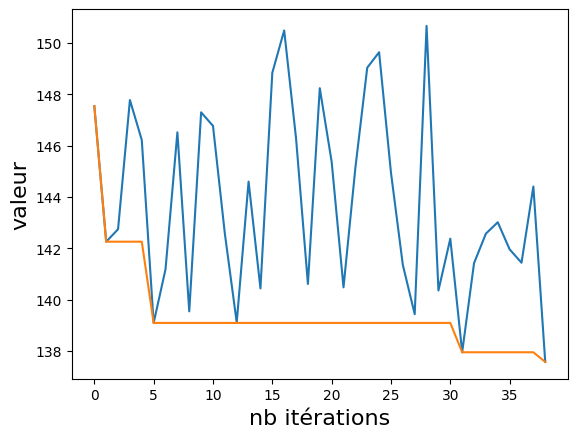

In [53]:
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
print(best_distances)
res = plt.plot(range(len(distances_list)), distances_list)
res = plt.plot(range(len(distances_list)),best_distances)

In [ ]:
# Mutation rate impact on results

In [71]:

bornes = deque(())

nb_tests = 100
wanted_generations = 20
jump_size = 1

bar = IntProgress(min=0, max=100, layout={"width" : "100%"})
display(bar)

citiesTuple = read_csv_to_tuple(dataset_file_path)
citiesSample = sample_N_from_tuple(citiesTuple, 50)
print(citiesSample)
generator = create_location_generator(citiesSample)
distances_km = calculate_distance_matrix(generator)
distances_freq = generate_distances_frequency(distances_km)
trucks = split_into_trucks(distances_freq,truck_number)


distances_list = deque(())
best_distances = deque(())
borne = solve_issue(trucks)
for new_mutation_rate in range(0,nb_tests,jump_size):
    generator = create_location_generator(citiesSample)
    distances_km = calculate_distance_matrix(generator)
    distances_freq = generate_distances_frequency(distances_km)
    trucks = split_into_trucks(distances_freq,truck_number)
    start_point = next(iter(distances_km.keys()))
    paths_and_maps = multistart(max_threads,6,citiesSample,trucks,population_size,wanted_generations,new_mutation_rate,tournament_size,start_point,start_time,children_size,elite_size)
    pathT = None
    mapT = None 
    sorted_list = sorted(paths_and_maps, key=lambda x: x[1])
    pathT, mapT = sorted_list[0][1],sorted_list[0][0]
    val = pathT
    best_distance_of_gen = val*100/borne      
    distances_list.append(best_distance_of_gen)    
    if len(best_distances) == 0 or best_distances[-1] > best_distance_of_gen:
        best_distances.append(best_distance_of_gen)
    else:
        best_distances.append(best_distances[-1])
                              
    bar.value += jump_size                                      

bar.close()

IntProgress(value=0, layout=Layout(width='100%'))

 the Function: read_csv_to_tuple took: 0.13654565811157227 seconds
 the Function: sample_N_from_tuple took: 0.010962963104248047 seconds
[['82187' '654' '44.159112311321' '1.8885625' 'Varen']
 ['88144' '56' '48.257528392857' '6.0765219642857'
  'Domèvre-sous-Montfort']
 ['43229' '610' '45.074225686275' '3.8005050980392' 'Saint-Vidal']
 ['59330' '2392' '50.471526256684' '3.2931175935829' 'Landas']
 ['78147' '476' '49.018009354839' '1.4839583870968'
  'Chaufour-lès-Bonnières']
 ['65387' '128' '43.587289317073' '-0.06948663414634' 'Saint-Lanne']
 ['85105' '529' '46.368394931507' '-0.90710821917808'
  'Le Gué-de-Velluire']
 ['62223' '291' '50.233080566038' '2.9124264150943' 'Chérisy']
 ['32114' '123' '43.353234367816' '0.44813540229885' 'Cuélas']
 ['76315' '1077' '49.745587350427' '0.6332511965812'
  'Grainville-la-Teinturière']
 ['36022' '410' '46.6269952' '1.6870197333333' 'Bouesse']
 ['51285' '139' '48.755351369863' '4.1831442465753' 'Haussimont']
 ['4181' '48' '43.98172453202' '6.11329

 the Function: calculate_distance_matrix took: 0.19235539436340332 seconds
 the Function: generate_distances_frequency took: 0.010962486267089844 seconds
 the Function: genetic_algorithm took: 0.4665088653564453 seconds
The truck n: 0 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Varen'] for a total of 43.27512484871777 h
 the Function: genetic_algorithm took: 0.602215051651001 seconds
The truck n: 0 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Gouarec', 'Courdemanche', 'Charentilly', 'Villegailhenc', 'Varen'] for a total of 55.73426421937947 h
 the Function: genetic_algorithm took: 0.7148385047912598 seconds
The truck n: 0 will do: ['Varen', 'Montgibaud', '

 the Function: genetic_algorithm took: 0.8469803333282471 seconds
The truck n: 0 will do: ['Varen', 'Boissise-le-Roi', 'Allainville', 'Clémont', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Varen'] for a total of 56.533782167074484 h
 the Function: genetic_algorithm took: 0.982527494430542 seconds
The truck n: 0 will do: ['Varen', 'Obterre', 'Bouesse', 'Allainville', 'Le Cardonnois', 'Lespesses', 'Landas', 'Chérisy', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'La Tessoualle', 'Le Gué-de-Velluire', 'Gouarec', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Boissise-le-Roi', 'Clémont', 'Varen'] for a total of 65.49100457730817 h
 the Function: genetic_algorithm took: 1.1190710067749023 seconds
The truck n: 0 will do: ['Varen', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'G

 the Function: genetic_algorithm took: 1.2191219329833984 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Obterre', 'Charentilly', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'La Tessoualle', 'Le Gué-de-Velluire', 'Gouarec', 'Varen'] for a total of 57.09936716864689 h
 the Function: genetic_algorithm took: 1.1669445037841797 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Anduze', 'Montbrand', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Villegailhenc', 'Varen'] for a total of 45.761243301676906 h
 the Function: genetic_algorithm took: 1.1667609214782715 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Vidal', 'Sainte-Feyre-la-

 the Function: genetic_algorithm took: 1.1764883995056152 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Montgibaud', 'Saint-Vidal', 'Susville', 'Lumbin', 'Montmaur', 'Montbrand', 'Saint-Jeannet', 'Anduze', 'Sainte-Feyre-la-Montagne', 'Villegailhenc', 'Varen'] for a total of 50.829986502867136 h
 the Function: genetic_algorithm took: 1.1675512790679932 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Susville', 'Montbrand', 'Saint-Jeannet', 'Montmaur', 'Lumbin', 'Saint-Vidal', 'Anduze', 'Varen'] for a total of 46.859721817775416 h
 the Function: genetic_algorithm took: 1.1610794067382812 seconds
The truck n: 1 will do: ['Varen', 'Saint-Vidal', 'Susville', 'Lumbin', 'Montmaur', 'Montbrand', 'Saint-Jeannet', 'Anduze', 'Villegailhenc', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Mouillac',

 the Function: genetic_algorithm took: 1.6866145133972168 seconds
The truck n: 1 will do: ['Varen', 'Thésy', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Saulx-lès-Champlon', 'Nancy', 'Fréménil', 'Domèvre-sous-Montfort', 'Arbecey', 'Robécourt', 'Noyers', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Landas', 'Chérisy', 'Lespesses', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Sincey-lès-Rouvray', 'Clémont', 'Varen'] for a total of 64.88262650768874 h
 the Function: genetic_algorithm took: 1.7394368648529053 seconds
The truck n: 1 will do: ['Varen', 'Saint-Arnoult-des-Bois', 'Allainville', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Chérisy', 'Les Ayvelles', 'Haussimont', 'Hampigny', 'Sincey-lès-Rouvray', 'Thésy', 'Arbecey', 'Noyers', 'Robécourt', 'Domèvre-sous-Montfort', 'Nancy', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Saulx-lès-Champlon', 'Landas', 'Lespesses', 'Le C

 the Function: genetic_algorithm took: 0.9262776374816895 seconds
The truck n: 2 will do: ['Varen', 'Perrignier', 'Thésy', 'Arbecey', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Hampigny', 'Saulx-lès-Champlon', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Nancy', 'Les Ayvelles', 'Haussimont', 'Sincey-lès-Rouvray', 'Varen'] for a total of 49.69243642896414 h
 the Function: genetic_algorithm took: 0.9956953525543213 seconds
The truck n: 2 will do: ['Varen', 'Sincey-lès-Rouvray', 'Thésy', 'Arbecey', 'Robécourt', 'Noyers', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Domèvre-sous-Montfort', 'Fréménil', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Perrignier', 'Varen'] for a total of 48.774082779806214 h
 the Function: genetic_algorithm took: 0.9000160694122314 seconds
The truck n: 2 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyer

 the Function: genetic_algorithm took: 0.31295299530029297 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Anduze', 'Varen'] for a total of 24.62640254068339 h
 the Function: genetic_algorithm took: 0.41860294342041016 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Anduze', 'Varen'] for a total of 24.62640254068339 h
 the Function: genetic_algorithm took: 0.489365816116333 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Anduze', 'Varen'] for a total of 24.62640254068339 h
 the Function: genetic_algorithm took: 0.5730946063995361 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur',

 the Function: genetic_algorithm took: 1.0319607257843018 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Clémont', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Allainville', 'Boissise-le-Roi', 'Saint-Arnoult-des-Bois', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Obterre', 'Varen'] for a total of 54.93057531033813 h
 the Function: genetic_algorithm took: 1.1585376262664795 seconds
The truck n: 0 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Gouarec', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Bouesse', 'Obterre', 'Varen'] for a total of 51.16430138020811 h
 the Function: genetic_algorithm took: 1.1516213417053223 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire

 the Function: genetic_algorithm took: 0.971501350402832 seconds
The truck n: 1 will do: ['Varen', 'Bouesse', 'Courdemanche', 'Charentilly', 'La Tessoualle', 'Gouarec', 'Le Gué-de-Velluire', 'Obterre', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 53.43171226290195 h
 the Function: genetic_algorithm took: 1.7477619647979736 seconds
The truck n: 2 will do: ['Varen', 'Clémont', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Haussimont', 'Boissise-le-Roi', 'Hampigny', 'Nancy', 'Fréménil', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Domèvre-sous-Montfort', 'Robécourt', 'Arbecey', 'Noyers', 'Sincey-lès-Rouvray', 'Varen'] for a total of 63.57355497445015 h
 the Function: genetic_algorithm took: 1.418670654296875 seconds
The truck n: 2 will do: ['Varen', 'A

 the Function: genetic_algorithm took: 1.1611053943634033 seconds
The truck n: 2 will do: ['Varen', 'Obterre', 'La Tessoualle', 'Gouarec', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Boissise-le-Roi', 'Allainville', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Chérisy', 'Landas', 'Lespesses', 'Le Cardonnois', 'Clémont', 'Bouesse', 'Varen'] for a total of 57.39805187670294 h
 the Function: genetic_algorithm took: 1.1570274829864502 seconds
The truck n: 2 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Chaufour-lès-Bonnières', 'Chérisy', 'Landas', 'Lespesses', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Saint-Arnoult-des-Bois', 'Gouarec', 'La Tessoualle', 'Charentilly', 'Courdemanche', 'Obterre', 'Bouesse', 'Varen'] for a total of 56.48628362695439 h
 the Function: genetic_algorithm took: 1.121652364730835 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'La Tessoualle', 'Charentilly', 'Courdemanche', 'Grainville-la-Teinturière'

 the Function: genetic_algorithm took: 1.283339262008667 seconds
The truck n: 2 will do: ['Varen', 'Clémont', 'Allainville', 'Saint-Arnoult-des-Bois', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Boissise-le-Roi', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Bouesse', 'Obterre', 'Varen'] for a total of 54.0652917525497 h
 the Function: genetic_algorithm took: 1.1838719844818115 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'Charentilly', 'La Tessoualle', 'Gouarec', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Varen'] for a total of 53.178370079785935 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.19987940788269043 seconds
 the Function: generate_distances_frequency took: 0.01195931434

 the Function: genetic_algorithm took: 0.11760616302490234 seconds
The truck n: 0 will do: ['Varen', 'Anduze', 'Montbrand', 'Saint-Jeannet', 'Montmaur', 'Susville', 'Lumbin', 'Perrignier', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Varen'] for a total of 25.045921608564168 h
 the Function: genetic_algorithm took: 0.22724676132202148 seconds
The truck n: 0 will do: ['Varen', 'Perrignier', 'Saint-Denis-en-Bugey', 'Lumbin', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Susville', 'Saint-Vidal', 'Anduze', 'Varen'] for a total of 28.43756746426058 h
 the Function: genetic_algorithm took: 0.38272643089294434 seconds
The truck n: 0 will do: ['Varen', 'Anduze', 'Montbrand', 'Saint-Jeannet', 'Montmaur', 'Susville', 'Lumbin', 'Perrignier', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Varen'] for a total of 25.045921608564168 h
 the Function: genetic_algorithm took: 0.46744322776794434 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montb

 the Function: genetic_algorithm took: 0.5174291133880615 seconds
The truck n: 0 will do: ['Varen', 'Anduze', 'Saint-Jeannet', 'Montbrand', 'Montmaur', 'Susville', 'Lumbin', 'Perrignier', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Varen'] for a total of 26.082940660646457 h
 the Function: genetic_algorithm took: 0.5871977806091309 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 25.775334004554793 h
 the Function: genetic_algorithm took: 0.862903356552124 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Varen'] for a total of 41.643878904495985 h
 the Function: genetic_algorithm took: 0.9725360870361328 seconds
The truck n: 1 will do: 

 the Function: genetic_algorithm took: 1.2498021125793457 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Fréménil', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 45.35185539190364 h
 the Function: genetic_algorithm took: 1.2315447330474854 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Varen'] for a total of 45.47749656579072 h
 the Function: genetic_algorithm took: 1.2544684410095215 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Montgibaud', 'Sainte-F

 the Function: genetic_algorithm took: 1.1598851680755615 seconds
The truck n: 1 will do: ['Varen', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Saint-Lanne', 'Jaxu', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 44.61717985606444 h
 the Function: genetic_algorithm took: 1.1534137725830078 seconds
The truck n: 1 will do: ['Varen', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Saint-Lanne', 'Jaxu', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 44.61717985606444 h
 the Function: genetic_algorithm took: 1.145491123199463 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Lumbin', 'Sus

 the Function: genetic_algorithm took: 1.4816296100616455 seconds
The truck n: 2 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 44.80053678557485 h
 the Function: genetic_algorithm took: 1.3052575588226318 seconds
The truck n: 2 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 44.80053678557485 h
 the Function: genetic_algorithm took: 1.0613081455230713 seconds
The truck n: 2 will do: ['Varen', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Montgibaud', 'Mouilla

 the Function: genetic_algorithm took: 0.5435731410980225 seconds
The truck n: 2 will do: ['Varen', 'Susville', 'Montbrand', 'Saint-Jeannet', 'Montmaur', 'Lumbin', 'Perrignier', 'Thésy', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Anduze', 'Varen'] for a total of 29.630795763073586 h
 the Function: genetic_algorithm took: 1.1857829093933105 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Perrignier', 'Thésy', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Varen'] for a total of 27.78030015126315 h
 the Function: genetic_algorithm took: 1.0133633613586426 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Perrignier', 'Thésy', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Varen'] for a total of 27.78030015126315 h
 the Function: genetic_algorithm took: 1.1977455615997314 seconds
The truck n: 2 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Thésy', 'Perrignier

 the Function: calculate_distance_matrix took: 0.20423364639282227 seconds
 the Function: generate_distances_frequency took: 0.010963916778564453 seconds
 the Function: genetic_algorithm took: 0.5262279510498047 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 45.81013751170716 h
 the Function: genetic_algorithm took: 0.7255609035491943 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Haussimont', 'Hampigny', 'Arbecey', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Noyers', 'Domèvre-sous-Montfort', 'Nancy', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Robécourt', 'Varen'] for a total of 54.152535133301654 h
 the Function: genetic_algorithm took

 the Function: genetic_algorithm took: 0.7769155502319336 seconds
The truck n: 0 will do: ['Varen', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Gouarec', 'La Tessoualle', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Obterre', 'Bouesse', 'Varen'] for a total of 57.564085554730056 h
 the Function: genetic_algorithm took: 0.8875458240509033 seconds
The truck n: 0 will do: ['Varen', 'Clémont', 'Allainville', 'Boissise-le-Roi', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Gouarec', 'La Tessoualle', 'Obterre', 'Bouesse', 'Varen'] for a total of 51.0275330895404 h
 the Function: genetic_algorithm took: 1.0136713981628418 seconds
The truck n: 0 will do: ['Varen', 'Obterre', 'Bouesse', 'Clémont', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Le

 the Function: genetic_algorithm took: 1.5010385513305664 seconds
The truck n: 1 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Chérisy', 'Lespesses', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Fréménil', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Arbecey', 'Thésy', 'Sincey-lès-Rouvray', 'Noyers', 'Robécourt', 'Domèvre-sous-Montfort', 'Hampigny', 'Haussimont', 'Varen'] for a total of 67.15980293124426 h
 the Function: genetic_algorithm took: 1.648575782775879 seconds
The truck n: 1 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Haussimont', 'Hampigny', 'Sincey-lès-Rouvray', 'Arbecey', 'Noyers', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Fréménil', 'Nancy', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Domèv

 the Function: genetic_algorithm took: 1.5317952632904053 seconds
The truck n: 1 will do: ['Varen', 'Arbecey', 'Noyers', 'Hampigny', 'Haussimont', 'Sincey-lès-Rouvray', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Lespesses', 'Chérisy', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Domèvre-sous-Montfort', 'Robécourt', 'Fréménil', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Thésy', 'Varen'] for a total of 65.83717704803229 h
 the Function: genetic_algorithm took: 1.6951820850372314 seconds
The truck n: 1 will do: ['Varen', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Chérisy', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Fréménil', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Thésy', 'Arbecey', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Hampigny', 'Haussimont', 'Le Cardonnois', 'Allainville', 'Boissise-

 the Function: genetic_algorithm took: 1.0814404487609863 seconds
The truck n: 1 will do: ['Varen', 'Sainte-Feyre-la-Montagne', 'Obterre', 'Charentilly', 'Courdemanche', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Gouarec', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Bouesse', 'Varen'] for a total of 50.24825298517416 h
 the Function: genetic_algorithm took: 0.8780868053436279 seconds
The truck n: 2 will do: ['Varen', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montbrand', 'Montmaur', 'Susville', 'Lumbin', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Montgibaud', 'Varen'] for a total of 39.99847205463363 h
 the Function: genetic_algorithm took: 0.868523359298706 seconds
The truck n: 2 will do: ['Varen', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Anduze', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Denis-en-

 the Function: genetic_algorithm took: 1.2137172222137451 seconds
The truck n: 2 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Mouillac', 'Le Gué-de-Velluire', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Courdemanche', 'Charentilly', 'La Tessoualle', 'Gouarec', 'Jaxu', 'Varen'] for a total of 55.40785876979059 h
 the Function: genetic_algorithm took: 1.0851457118988037 seconds
The truck n: 2 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Villegailhenc', 'Varen'] for a total of 45.108816047537864 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.19840502738952637 seconds
 the Function: generate_distances_frequency took: 0.009966611862182617 seconds
 the Function: genetic_algorithm took: 0.5037147998809

 the Function: genetic_algorithm took: 0.5332615375518799 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Obterre', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Le Cardonnois', 'Lespesses', 'Chérisy', 'Landas', 'Grainville-la-Teinturière', 'Gouarec', 'Charentilly', 'La Tessoualle', 'Le Gué-de-Velluire', 'Varen'] for a total of 59.65889565667076 h
 the Function: genetic_algorithm took: 0.703350305557251 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Obterre', 'Le Gué-de-Velluire', 'La Tessoualle', 'Chaufour-lès-Bonnières', 'Chérisy', 'Landas', 'Lespesses', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Gouarec', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Varen'] for a total of 64.085785945019 h
 the Function: genetic_algorithm took: 0.8362348079681396 seconds
The truck n: 0 will do: ['Varen', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Grai

 the Function: genetic_algorithm took: 0.5247037410736084 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Thésy', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur', 'Montbrand', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 26.77678066092724 h
 the Function: genetic_algorithm took: 0.6163971424102783 seconds
The truck n: 0 will do: ['Varen', 'Anduze', 'Susville', 'Perrignier', 'Thésy', 'Saint-Denis-en-Bugey', 'Lumbin', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Saint-Vidal', 'Varen'] for a total of 32.79116321856838 h
 the Function: genetic_algorithm took: 0.7070965766906738 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Thésy', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur', 'Montbrand', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 26.77678066092724 h
 the Function: genetic_algorithm took: 0.9128513336181641 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac'

 the Function: genetic_algorithm took: 1.3817567825317383 seconds
The truck n: 1 will do: ['Varen', 'Domèvre-sous-Montfort', 'Robécourt', 'Arbecey', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Fréménil', 'Nancy', 'Saulx-lès-Champlon', 'Noyers', 'Haussimont', 'Le Cardonnois', 'Boissise-le-Roi', 'Clémont', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Chérisy', 'Landas', 'Les Ayvelles', 'Hampigny', 'Sincey-lès-Rouvray', 'Varen'] for a total of 71.3176403909269 h
 the Function: genetic_algorithm took: 1.4335379600524902 seconds
The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Noyers', 'Arbecey', 'Domèvre-sous-Montfort', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Fréménil', 'Nancy', 'Robécourt', 'Saulx-lès-Champlon', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Landas', 'Chérisy', 'Lespesses', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissi

 the Function: genetic_algorithm took: 1.7609620094299316 seconds the Function: genetic_algorithm took: 2.0193467140197754 seconds
The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Domèvre-sous-Montfort', 'Arbecey', 'Robécourt', 'Noyers', 'Hampigny', 'Boissise-le-Roi', 'Allainville', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Landas', 'Chérisy', 'Lespesses', 'Le Cardonnois', 'Saint-Arnoult-des-Bois', 'Clémont', 'Varen'] for a total of 61.98543529989051 h

The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Chérisy', 'Lespesses', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Arbecey', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Hampigny', 'Haussimont', 'Le 

 the Function: genetic_algorithm took: 0.9841368198394775 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'Charentilly', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Le Cardonnois', 'Landas', 'Chérisy', 'Lespesses', 'Grainville-la-Teinturière', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Varen'] for a total of 52.04129638428182 h
 the Function: genetic_algorithm took: 0.9711799621582031 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Allainville', 'Clémont', 'Boissise-le-Roi', 'Le Cardonnois', 'Landas', 'Chérisy', 'Lespesses', 'Gouarec', 'La Tessoualle', 'Obterre', 'Varen'] for a total of 59.006492119870146 h
 the Function: genetic_algorithm took: 0.9677772521972656 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'La Tessoualle', 'Gouarec', 'Grainville-la-Teinturière', 'Chaufour-lès-Bo

 the Function: calculate_distance_matrix took: 0.19180583953857422 seconds
 the Function: generate_distances_frequency took: 0.01096343994140625 seconds
 the Function: genetic_algorithm took: 0.4873695373535156 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Obterre', 'Clémont', 'Allainville', 'Boissise-le-Roi', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Charentilly', 'Varen'] for a total of 57.91727807541973 h
 the Function: genetic_algorithm took: 0.6804006099700928 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Clémont', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Chaufour-lès-Bonnières', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Allainville', 'Boissise-le-Roi', 'Saint-Arnoult-des-Bois', 'Charentilly', 'Obterre', 'Le Gué-de-Velluire', 'Varen'] for a total of 62.238758340890286 

 the Function: genetic_algorithm took: 0.7932333946228027 seconds
The truck n: 0 will do: ['Varen', 'Charentilly', 'Courdemanche', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Obterre', 'Bouesse', 'Varen'] for a total of 53.01685532166388 h
 the Function: genetic_algorithm took: 0.9422571659088135 seconds
The truck n: 0 will do: ['Varen', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Gouarec', 'Le Gué-de-Velluire', 'Varen'] for a total of 56.67234850868501 h
 the Function: genetic_algorithm took: 1.082787275314331 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Clémont', 'Boissise-le-Roi', 'Allainville

 the Function: genetic_algorithm took: 1.083036184310913 seconds
The truck n: 0 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Varen'] for a total of 45.91603095537042 h
 the Function: genetic_algorithm took: 1.3896980285644531 seconds
The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Arbecey', 'Robécourt', 'Nambsheim', 'Niedersoultzbach', 'Fréménil', 'Nancy', 'Pontpierre', 'Saulx-lès-Champlon', 'Haussimont', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Saint-Arnoult-des-Bois', 'Allainville', 'Clémont', 'Boissise-le-Roi', 'Chaufour-lès-Bonnières', 'Lespesses', 'Chérisy', 'Landas', 'Les Ayvelles', 'Domèvre-sous-Montfort', 'Noyers', 'Hampigny', 'Varen'] for a total of 72.72272107375802 h
 the Function: genetic_algorithm took: 1.4461803436279297 seconds
The truck n: 1 will do: ['Varen', '

 the Function: genetic_algorithm took: 1.2546348571777344 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Lumbin', 'Susville', 'Montmaur', 'Montbrand', 'Saint-Jeannet', 'Anduze', 'Villegailhenc', 'Varen'] for a total of 45.333273192667704 h
 the Function: genetic_algorithm took: 1.243283987045288 seconds
The truck n: 1 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montbrand', 'Montmaur', 'Lumbin', 'Susville', 'Saint-Vidal', 'Varen'] for a total of 46.456410902434435 h
 the Function: genetic_algorithm took: 1.281426191329956 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Lumbin', 'Su

 the Function: genetic_algorithm took: 1.5146493911743164 seconds
The truck n: 1 will do: ['Varen', 'Saint-Arnoult-des-Bois', 'Allainville', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Chérisy', 'Lespesses', 'Landas', 'Saulx-lès-Champlon', 'Haussimont', 'Hampigny', 'Sincey-lès-Rouvray', 'Noyers', 'Robécourt', 'Arbecey', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Fréménil', 'Domèvre-sous-Montfort', 'Nancy', 'Les Ayvelles', 'Boissise-le-Roi', 'Clémont', 'Varen'] for a total of 71.14382303629952 h
 the Function: genetic_algorithm took: 1.680260181427002 seconds
The truck n: 1 will do: ['Varen', 'Saint-Arnoult-des-Bois', 'Allainville', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Chérisy', 'Lespesses', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Hampigny', 'Haussimont', 'Boissise-le-Roi', 'Clémont', 'Sincey-lès-Rouvray', 'Arbecey', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Fréménil', 'Nancy', 'Domèvre-sous-Montfort', 

 the Function: genetic_algorithm took: 1.1467366218566895 seconds
The truck n: 2 will do: ['Varen', 'Saint-Denis-en-Bugey', 'Perrignier', 'Thésy', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Domèvre-sous-Montfort', 'Arbecey', 'Robécourt', 'Noyers', 'Varen'] for a total of 47.88805232536345 h
 the Function: genetic_algorithm took: 1.1601510047912598 seconds
The truck n: 2 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Pontpierre', 'Nancy', 'Nambsheim', 'Niedersoultzbach', 'Fréménil', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 48.39252187759288 h
 the Function: genetic_algorithm took: 1.152669906616211 seconds
The truck n: 2 will do: ['Varen', 'Sincey-lès-Rouvray', 'Arbecey', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Hampigny', 

 the Function: calculate_distance_matrix took: 0.191359281539917 seconds
 the Function: generate_distances_frequency took: 0.009966373443603516 seconds
 the Function: genetic_algorithm took: 0.41030168533325195 seconds
The truck n: 0 will do: ['Varen', 'La Tessoualle', 'Gouarec', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Allainville', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Boissise-le-Roi', 'Clémont', 'Bouesse', 'Obterre', 'Varen'] for a total of 52.979102196658516 h
 the Function: genetic_algorithm took: 0.6469030380249023 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Obterre', 'Charentilly', 'Saint-Arnoult-des-Bois', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Chaufour-lès-Bonnières', 'Le Cardonnois', 'Chérisy', 'Lespesses', 'Landas', 'Grainville-la-Teinturière', 'Gouarec', 'Courdemanche', 'La Tessoualle', 'Varen'] for a total of 56.462483881469595 h
 the Function: genetic_algorithm took: 0.

 the Function: genetic_algorithm took: 0.9498229026794434 seconds
The truck n: 0 will do: ['Varen', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Allainville', 'Boissise-le-Roi', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Clémont', 'Obterre', 'Bouesse', 'Varen'] for a total of 52.558439584093456 h
 the Function: genetic_algorithm took: 1.0818877220153809 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Charentilly', 'Gouarec', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Allainville', 'Le Cardonnois', 'Lespesses', 'Landas', 'Chérisy', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Boissise-le-Roi', 'Clémont', 'Obterre', 'La Tessoualle', 'Le Gué-de-Velluire', 'Varen'] for a total of 59.87608685002609 h
 the Function: genetic_algorithm took: 1.2125651836395264 seconds
The truck n: 0 will do: ['Varen', 'Le Gué-de-Velluire', 'Gouarec', 'Grainville-la-Tei

 the Function: genetic_algorithm took: 1.3712472915649414 seconds
The truck n: 1 will do: ['Varen', 'Allainville', 'Clémont', 'Sincey-lès-Rouvray', 'Noyers', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Nancy', 'Saulx-lès-Champlon', 'Domèvre-sous-Montfort', 'Arbecey', 'Robécourt', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Landas', 'Lespesses', 'Chérisy', 'Le Cardonnois', 'Boissise-le-Roi', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Saint-Arnoult-des-Bois', 'Varen'] for a total of 69.11859965637989 h
 the Function: genetic_algorithm took: 1.3186872005462646 seconds
The truck n: 1 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Les Ayvelles', 'Haussimont', 'Hampigny', 'Sincey-lès-Rouvray', 'Arbecey', 'Noyers', 'Robécourt', 'Domèvre-sous-Montfort', 'Fréménil', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Nancy'

 the Function: genetic_algorithm took: 1.5681638717651367 seconds
The truck n: 1 will do: ['Varen', 'Haussimont', 'Hampigny', 'Noyers', 'Robécourt', 'Arbecey', 'Domèvre-sous-Montfort', 'Nambsheim', 'Niedersoultzbach', 'Fréménil', 'Nancy', 'Pontpierre', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Landas', 'Chérisy', 'Lespesses', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Sincey-lès-Rouvray', 'Thésy', 'Varen'] for a total of 65.62556732672896 h
 the Function: genetic_algorithm took: 1.6269667148590088 seconds
The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Clémont', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Boissise-le-Roi', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Domèvre-sous-Montfort', '

 the Function: genetic_algorithm took: 1.1704707145690918 seconds
The truck n: 2 will do: ['Varen', 'Gouarec', 'La Tessoualle', 'Clémont', 'Allainville', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Boissise-le-Roi', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Varen'] for a total of 56.6994400048302 h
 the Function: genetic_algorithm took: 1.1628916263580322 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Clémont', 'Allainville', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Boissise-le-Roi', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Gouarec', 'La Tessoualle', 'Obterre', 'Varen'] for a total of 55.47253508636492 h
 the Function: genetic_algorithm took: 1.143958568572998 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Clémont', 'Allainville', 'Boissise-le-Roi', 

 the Function: genetic_algorithm took: 0.9292581081390381 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Saint-Jeannet', 'Montbrand', 'Montmaur', 'Susville', 'Lumbin', 'Perrignier', 'Thésy', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Varen'] for a total of 26.781200654832222 h
 the Function: genetic_algorithm took: 0.9072902202606201 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Saint-Jeannet', 'Montbrand', 'Montmaur', 'Susville', 'Lumbin', 'Perrignier', 'Thésy', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Varen'] for a total of 26.781200654832222 h
 the Function: genetic_algorithm took: 0.765763521194458 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Saint-Vidal', 'Varen'] for a total of 28.859667201490858 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.19136285781860352 seconds
 the Function: generate_

 the Function: generate_distances_frequency took: 0.009966611862182617 seconds
 the Function: genetic_algorithm took: 0.3080008029937744 seconds the Function: genetic_algorithm took: 0.24720406532287598 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 25.226343138665776 h
 the Function: genetic_algorithm took: 0.3618204593658447 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 25.226343138665776 h

The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 25.226343138665776 h
 the Function: genetic_algorithm took: 0.4644463062286377 seconds
The truck n: 0 will do: ['Varen', 'Sai

 the Function: genetic_algorithm took: 1.0654079914093018 seconds the Function: genetic_algorithm took: 1.0723841190338135 seconds
The truck n: 0 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 40.98955611248727 h

The truck n: 0 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 40.98955611248727 h
 the Function: genetic_algorithm took: 1.5151638984680176 seconds
The truck n: 1 will do: ['Varen', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Chérisy', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Pontpierre', 'Niedersoultzbach

 the Function: genetic_algorithm took: 1.5762693881988525 seconds
The truck n: 1 will do: ['Varen', 'Clémont', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Boissise-le-Roi', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Pontpierre', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Nancy', 'Domèvre-sous-Montfort', 'Arbecey', 'Robécourt', 'Noyers', 'Hampigny', 'Sincey-lès-Rouvray', 'Varen'] for a total of 63.77034761847168 h
 the Function: genetic_algorithm took: 1.626605749130249 seconds
The truck n: 1 will do: ['Varen', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Boissise-le-Roi', 'Clémont', 'Haussimont', 'Hampigny', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Arbecey', 'Noyers', 'Robécourt', 'Domèvre-sous-Montfort', 'Fréménil', 'Nancy',

 the Function: genetic_algorithm took: 1.196220874786377 seconds
The truck n: 2 will do: ['Varen', 'Clémont', 'Charentilly', 'Courdemanche', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Gouarec', 'Le Gué-de-Velluire', 'La Tessoualle', 'Obterre', 'Bouesse', 'Varen'] for a total of 54.37056656272354 h
 the Function: genetic_algorithm took: 1.1942157745361328 seconds
The truck n: 2 will do: ['Varen', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Varen'] for a total of 52.60096954622735 h
 the Function: genetic_algorithm took: 1.0885186195373535 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'Clémont', 'Boissise-le-Roi', '

 the Function: genetic_algorithm took: 1.237964391708374 seconds
The truck n: 2 will do: ['Varen', 'Gouarec', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Chaufour-lès-Bonnières', 'Boissise-le-Roi', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Saint-Arnoult-des-Bois', 'Allainville', 'Clémont', 'Obterre', 'Bouesse', 'Varen'] for a total of 54.61681019840714 h
 the Function: genetic_algorithm took: 1.2048089504241943 seconds
The truck n: 2 will do: ['Varen', 'La Tessoualle', 'Gouarec', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Chérisy', 'Landas', 'Le Cardonnois', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Obterre', 'Clémont', 'Bouesse', 'Varen'] for a total of 53.85342120729743 h
 the Function: genetic_algorithm took: 1.3660390377044678 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'Clémont', 'Allainville', 'Boissise-le-Roi', 'Le Cardonnois', 'Chérisy', 'L

 the Function: genetic_algorithm took: 0.3949432373046875 seconds
The truck n: 0 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Mouillac', 'Corme-Royal', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Charentilly', 'Courdemanche', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Varen'] for a total of 44.80944420612369 h
 the Function: genetic_algorithm took: 0.5566596984863281 seconds
The truck n: 0 will do: ['Varen', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Villegailhenc', 'Varen'] for a total of 46.94297735257782 h
 the Function: genetic_algorithm took: 0.749537467956543 seconds
The truck n: 0 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Charentilly', 'Obterre', 

 the Function: genetic_algorithm took: 1.2566509246826172 seconds
The truck n: 0 will do: ['Varen', 'Perrignier', 'Thésy', 'Arbecey', 'Robécourt', 'Domèvre-sous-Montfort', 'Saulx-lès-Champlon', 'Nancy', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Les Ayvelles', 'Landas', 'Lespesses', 'Chérisy', 'Le Cardonnois', 'Haussimont', 'Hampigny', 'Noyers', 'Sincey-lès-Rouvray', 'Varen'] for a total of 57.02297801707327 h
 the Function: genetic_algorithm took: 1.4081439971923828 seconds
The truck n: 0 will do: ['Varen', 'Perrignier', 'Thésy', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Fréménil', 'Nancy', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Landas', 'Lespesses', 'Chérisy', 'Le Cardonnois', 'Haussimont', 'Hampigny', 'Domèvre-sous-Montfort', 'Arbecey', 'Robécourt', 'Noyers', 'Sincey-lès-Rouvray', 'Varen'] for a total of 56.51741455479225 h
 the Function: genetic_algorithm took: 1.2427213191986084 seconds
The truck n: 1 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Allainv

 the Function: genetic_algorithm took: 1.1535992622375488 seconds
The truck n: 1 will do: ['Varen', 'Anduze', 'Saint-Jeannet', 'Montbrand', 'Montmaur', 'Susville', 'Lumbin', 'Saint-Vidal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 47.97423070279711 h
 the Function: genetic_algorithm took: 1.080282211303711 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Lumbin', 'Susville', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Anduze', 'Villegailhenc', 'Varen'] for a total of 46.07007831625068 h
 the Function: genetic_algorithm took: 1.1440513134002686 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Lumbin', 'Sus

 the Function: genetic_algorithm took: 1.796051025390625 seconds
The truck n: 1 will do: ['Varen', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Haussimont', 'Hampigny', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Domèvre-sous-Montfort', 'Noyers', 'Robécourt', 'Arbecey', 'Thésy', 'Sincey-lès-Rouvray', 'Clémont', 'Varen'] for a total of 68.29758195261505 h
 the Function: genetic_algorithm took: 1.8555104732513428 seconds
The truck n: 1 will do: ['Varen', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Chérisy', 'Lespesses', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Nancy', 'Domèvre-sous-Montfort', 'Robécourt', 'Arbecey', 'Thésy', 'Noyers', 'Hampigny', 'Hauss

 the Function: genetic_algorithm took: 1.1433861255645752 seconds
The truck n: 2 will do: ['Varen', 'Obterre', 'Clémont', 'Boissise-le-Roi', 'Le Cardonnois', 'Landas', 'Chérisy', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Allainville', 'Saint-Arnoult-des-Bois', 'Gouarec', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Bouesse', 'Varen'] for a total of 56.089435622345995 h
 the Function: genetic_algorithm took: 1.3006720542907715 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Le Cardonnois', 'Landas', 'Chérisy', 'Lespesses', 'Grainville-la-Teinturière', 'Gouarec', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Varen'] for a total of 52.18690338726493 h
 the Function: genetic_algorithm took: 1.2232697010040283 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'Charentilly', 'Clémont', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'La T

 the Function: calculate_distance_matrix took: 0.18887734413146973 seconds
 the Function: generate_distances_frequency took: 0.01096343994140625 seconds
 the Function: genetic_algorithm took: 0.18139386177062988 seconds
The truck n: 0 will do: ['Varen', 'Saint-Denis-en-Bugey', 'Perrignier', 'Thésy', 'Nambsheim', 'Arbecey', 'Noyers', 'Robécourt', 'Nancy', 'Fréménil', 'Niedersoultzbach', 'Pontpierre', 'Saulx-lès-Champlon', 'Domèvre-sous-Montfort', 'Haussimont', 'Les Ayvelles', 'Hampigny', 'Sincey-lès-Rouvray', 'Varen'] for a total of 51.36289088567155 h
 the Function: genetic_algorithm took: 0.471160888671875 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Thésy', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Nancy', 'Fréménil', 'Robécourt', 'Noyers', 'Arbecey', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Domèvre-sous-Montfort', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 51.238493629187104 h
 the Function: genetic_algorithm took:

 the Function: genetic_algorithm took: 1.0595760345458984 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Nancy', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 45.24099088730368 h
 the Function: genetic_algorithm took: 1.1971170902252197 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 44.60448197949573 h
 the Function: genetic_algorithm took: 1.3346569538116455 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy

 the Function: genetic_algorithm took: 1.571052074432373 seconds
The truck n: 0 will do: ['Varen', 'Clémont', 'Saint-Arnoult-des-Bois', 'Allainville', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Lespesses', 'Chérisy', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Domèvre-sous-Montfort', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Nancy', 'Hampigny', 'Haussimont', 'Boissise-le-Roi', 'Sincey-lès-Rouvray', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Varen'] for a total of 70.25522571002058 h
 the Function: genetic_algorithm took: 1.7580256462097168 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Thésy', 'Arbecey', 'Robécourt', 'Noyers', 'Hampigny', 'Haussimont', 'Domèvre-sous-Montfort', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Nancy', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Landas', 'Chérisy', 'Lespesses', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'All

 the Function: genetic_algorithm took: 1.2319540977478027 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Varen'] for a total of 42.97301305952942 h
 the Function: genetic_algorithm took: 1.567988395690918 seconds
The truck n: 2 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Chérisy', 'Lespesses', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Domèvre-sous-Montfort', 'Robécourt', 'Arbecey', 'Noyers', 'Hampigny', 'Haussimont', 'Sincey-lès-Rouvray', 'Varen'] for a total of 58.810947861089915 h
 the Function: genetic_algorithm took: 1.5173096656799316 seconds
The truck n: 2 will do: ['Varen', 

 the Function: genetic_algorithm took: 1.1700429916381836 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'La Tessoualle', 'Gouarec', 'Clémont', 'Boissise-le-Roi', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Allainville', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Varen'] for a total of 53.25847089106885 h
 the Function: genetic_algorithm took: 1.136970043182373 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'La Tessoualle', 'Gouarec', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Varen'] for a total of 52.847042081933004 h
 the Function: genetic_algorithm took: 0.8003275394439697 seconds
The truck n: 2 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-

 the Function: calculate_distance_matrix took: 0.19933271408081055 seconds
 the Function: generate_distances_frequency took: 0.009965896606445312 seconds
 the Function: genetic_algorithm took: 0.5322167873382568 seconds
The truck n: 0 will do: ['Varen', 'Le Gué-de-Velluire', 'La Tessoualle', 'Gouarec', 'Clémont', 'Boissise-le-Roi', 'Le Cardonnois', 'Landas', 'Chérisy', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Allainville', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Varen'] for a total of 54.584025550470784 h
 the Function: genetic_algorithm took: 0.6879563331604004 seconds
The truck n: 0 will do: ['Varen', 'Bouesse', 'Obterre', 'Boissise-le-Roi', 'Le Cardonnois', 'Landas', 'Chérisy', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Allainville', 'Saint-Arnoult-des-Bois', 'Clémont', 'Courdemanche', 'Charentilly', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Varen'] for a total of 57.84152583527611

 the Function: genetic_algorithm took: 0.9435844421386719 seconds
The truck n: 0 will do: ['Varen', 'Saint-Denis-en-Bugey', 'Perrignier', 'Thésy', 'Arbecey', 'Domèvre-sous-Montfort', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Haussimont', 'Hampigny', 'Nancy', 'Robécourt', 'Noyers', 'Sincey-lès-Rouvray', 'Varen'] for a total of 47.336669079813234 h
 the Function: genetic_algorithm took: 1.0807561874389648 seconds
The truck n: 0 will do: ['Varen', 'Saint-Denis-en-Bugey', 'Perrignier', 'Thésy', 'Arbecey', 'Domèvre-sous-Montfort', 'Robécourt', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Noyers', 'Sincey-lès-Rouvray', 'Varen'] for a total of 46.76043366700601 h
 the Function: genetic_algorithm took: 1.2115058898925781 seconds
The truck n: 0 will do: ['Varen', 'Saint-Denis-en-Bugey', 'Perrignier', 'Thésy', 'Arbecey', 'Noyers', 'Robécourt', 'Domèvre-s

 the Function: genetic_algorithm took: 0.9361343383789062 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Varen'] for a total of 41.18525352524741 h
 the Function: genetic_algorithm took: 1.0372905731201172 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Jaxu', 'Montgibaud', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Saint-Lanne', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Varen'] for a total of 52.344513469876055 h
 the Function: genetic_algorithm took: 1.4314963817596436 seconds
The truck n: 1 will do: ['Varen', 'Jaxu', 'Cuélas', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Saint-Lanne', 'Villegailhe

 the Function: genetic_algorithm took: 1.5720584392547607 seconds
The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Noyers', 'Robécourt', 'Domèvre-sous-Montfort', 'Arbecey', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Fréménil', 'Nancy', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Landas', 'Lespesses', 'Chérisy', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Haussimont', 'Clémont', 'Varen'] for a total of 61.42568205595178 h
 the Function: genetic_algorithm took: 1.5141730308532715 seconds
The truck n: 1 will do: ['Varen', 'Nambsheim', 'Niedersoultzbach', 'Fréménil', 'Domèvre-sous-Montfort', 'Robécourt', 'Arbecey', 'Noyers', 'Les Ayvelles', 'Haussimont', 'Hampigny', 'Sincey-lès-Rouvray', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Lespesses', 'Chérisy', 'Landas', 'Pontpierre', 'Saulx-

 the Function: genetic_algorithm took: 0.8335607051849365 seconds
The truck n: 2 will do: ['Varen', 'Obterre', 'Charentilly', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Bouesse', 'Varen'] for a total of 54.986688908394555 h
 the Function: genetic_algorithm took: 0.9652588367462158 seconds
The truck n: 2 will do: ['Varen', 'Obterre', 'Bouesse', 'Clémont', 'Allainville', 'Boissise-le-Roi', 'Le Cardonnois', 'Lespesses', 'Landas', 'Chérisy', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'La Tessoualle', 'Gouarec', 'Varen'] for a total of 53.458192026405996 h
 the Function: genetic_algorithm took: 0.9642596244812012 seconds
The truck n: 2 will do: ['Varen', 'Obterre', 'Bouesse', 'Clémont', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'All

 the Function: genetic_algorithm took: 1.2854130268096924 seconds the Function: genetic_algorithm took: 1.1638166904449463 seconds
The truck n: 2 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Perrignier', 'Varen'] for a total of 46.482120470936856 h

The truck n: 2 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Perrignier', 'Varen'] for a total of 46.482120470936856 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.19036293029785156 seconds
 the Function: generate_distances_frequency took: 0.009966611862182617 seconds
 the Function: genetic_al

 the Function: genetic_algorithm took: 0.13255691528320312 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 25.4470632477766 h
 the Function: genetic_algorithm took: 0.35541772842407227 seconds
The truck n: 0 will do: ['Varen', 'Anduze', 'Saint-Vidal', 'Saint-Jeannet', 'Montbrand', 'Montmaur', 'Susville', 'Perrignier', 'Saint-Denis-en-Bugey', 'Lumbin', 'Varen'] for a total of 29.28840879006598 h
 the Function: genetic_algorithm took: 0.44512486457824707 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Anduze', 'Varen'] for a total of 25.86144698895878 h
 the Function: genetic_algorithm took: 0.534825325012207 seconds
The truck n: 0 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur',

 the Function: genetic_algorithm took: 0.6498260498046875 seconds
The truck n: 0 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 40.653411501703566 h
 the Function: genetic_algorithm took: 0.6752469539642334 seconds
The truck n: 0 will do: ['Varen', 'Villegailhenc', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Varen'] for a total of 44.234344582892646 h
 the Function: genetic_algorithm took: 0.7905921936035156 seconds
The truck n: 0 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Gouarec', 'La Tessoualle', 'Charentilly', 'Courdemanche', 'Obterre

 the Function: genetic_algorithm took: 0.6382620334625244 seconds
The truck n: 1 will do: ['Varen', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Montmaur', 'Lumbin', 'Susville', 'Montbrand', 'Saint-Jeannet', 'Anduze', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Mouillac', 'Corme-Royal', 'Varen'] for a total of 47.97927166502518 h
 the Function: genetic_algorithm took: 1.3829286098480225 seconds
The truck n: 1 will do: ['Varen', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Anduze', 'Montbrand', 'Saint-Jeannet', 'Montmaur', 'Susville', 'Lumbin', 'Saint-Vidal', 'Varen'] for a total of 46.18348323344223 h
 the Function: genetic_algorithm took: 1.0908386707305908 seconds
The truck n: 1 will do: ['Varen', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Anduze', 'Montbrand', 'Saint-Jeannet', 'Montmaur', 'Susville', 'Lumbin', 'Sa

 the Function: genetic_algorithm took: 1.0562076568603516 seconds
The truck n: 1 will do: ['Varen', 'Haussimont', 'Sincey-lès-Rouvray', 'Arbecey', 'Noyers', 'Robécourt', 'Nancy', 'Pontpierre', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Hampigny', 'Domèvre-sous-Montfort', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Perrignier', 'Thésy', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 53.58858205098076 h
 the Function: genetic_algorithm took: 1.2346105575561523 seconds
The truck n: 1 will do: ['Varen', 'Noyers', 'Robécourt', 'Domèvre-sous-Montfort', 'Fréménil', 'Nancy', 'Pontpierre', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Haussimont', 'Hampigny', 'Sincey-lès-Rouvray', 'Thésy', 'Nambsheim', 'Niedersoultzbach', 'Arbecey', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 53.33461683108829 h
 the Function: genetic_algorithm took: 1.3475980758666992 seconds
The truck n: 1 will do: ['Varen', 'Saint-Denis-en-Bugey', 'Nambsheim', 'Niedersoultzbach', 'Fréménil', 'Domèvre-sous-Montfort'

 the Function: genetic_algorithm took: 1.1540019512176514 seconds
The truck n: 2 will do: ['Varen', 'La Tessoualle', 'Gouarec', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Varen'] for a total of 52.41397987621567 h
 the Function: genetic_algorithm took: 1.1382319927215576 seconds
The truck n: 2 will do: ['Varen', 'Clémont', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Le Cardonnois', 'Lespesses', 'Chérisy', 'Landas', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'La Tessoualle', 'Gouarec', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Varen'] for a total of 55.37144746078239 h
 the Function: genetic_algorithm took: 1.1202919483184814 seconds
The truck n: 2 will do: ['Varen', 'La Tessoualle', 'Gouarec', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-l

 the Function: genetic_algorithm took: 1.1915903091430664 seconds the Function: genetic_algorithm took: 1.263350248336792 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Clémont', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'Obterre', 'La Tessoualle', 'Gouarec', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Allainville', 'Boissise-le-Roi', 'Varen'] for a total of 62.69347300810802 h

The truck n: 2 will do: ['Varen', 'Obterre', 'Bouesse', 'Clémont', 'Boissise-le-Roi', 'Saint-Arnoult-des-Bois', 'Courdemanche', 'Charentilly', 'La Tessoualle', 'Gouarec', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Allainville', 'Varen'] for a total of 60.07768364955897 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.19037151336669922 seconds
 the Function: generate_distances_frequency took: 0.01096320152

 the Function: genetic_algorithm took: 0.3638191223144531 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Domèvre-sous-Montfort', 'Nancy', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Haussimont', 'Hampigny', 'Noyers', 'Robécourt', 'Arbecey', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 44.76652947484704 h
 the Function: genetic_algorithm took: 0.6005339622497559 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Domèvre-sous-Montfort', 'Robécourt', 'Noyers', 'Arbecey', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Varen'] for a total of 44.536699619429086 h
 the Function: genetic_algorithm took: 0.8144698143005371 seconds
The truck n: 0 will do: ['Varen', 'Sincey-lès-Rouvray', 'Arbecey', 'Nancy', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Haussimont

 the Function: genetic_algorithm took: 0.722902774810791 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montbrand', 'Montmaur', 'Lumbin', 'Susville', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Varen'] for a total of 40.91121997100213 h
 the Function: genetic_algorithm took: 0.7400388717651367 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Vidal', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Varen'] for a total of 41.03741294834619 h
 the Function: genetic_algorithm took: 0.9817228317260742 seconds
The truck n: 0 will do: ['Varen', 'Landas', 'Chérisy', 'Lespesses', 'Le Cardonnois', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'La Tessoualle', 'Le

 the Function: genetic_algorithm took: 0.9452719688415527 seconds
The truck n: 2 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Gouarec', 'Le Gué-de-Velluire', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Varen'] for a total of 48.5281173690326 h
 the Function: genetic_algorithm took: 1.2601213455200195 seconds
The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Thésy', 'Arbecey', 'Noyers', 'Robécourt', 'Domèvre-sous-Montfort', 'Fréménil', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Nancy', 'Saulx-lès-Champlon', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Landas', 'Lespesses', 'Chérisy', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Saint-Arnoult-des-Bois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Varen'] for a total of 62.09004836900144 h
 the Function: genetic_algorithm took: 1.3477346897125244 seconds
The truck n: 1 will do: ['

 the Function: genetic_algorithm took: 1.2107524871826172 seconds
The truck n: 1 will do: ['Varen', 'Mouillac', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Varen'] for a total of 46.74246304557893 h
 the Function: genetic_algorithm took: 1.3286688327789307 seconds
The truck n: 1 will do: ['Varen', 'Mouillac', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Varen'] for a total of 46.74246304557893 h
 the Function: genetic_algorithm took: 1.1357195377349854 seconds
The truck n: 1 will do: ['Varen', 'Villegailhenc', 'Anduze', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Susville', 'Lumbin', 'Saint-Denis-en-Bugey', 'Saint-Vidal', 'Sainte-Feyre-la-M

 the Function: genetic_algorithm took: 1.2128629684448242 seconds
The truck n: 2 will do: ['Varen', 'La Tessoualle', 'Gouarec', 'Charentilly', 'Courdemanche', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Allainville', 'Boissise-le-Roi', 'Clémont', 'Bouesse', 'Obterre', 'Varen'] for a total of 52.582168465971534 h
 the Function: genetic_algorithm took: 1.2048871517181396 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Clémont', 'Boissise-le-Roi', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Saint-Arnoult-des-Bois', 'Allainville', 'Gouarec', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Obterre', 'Varen'] for a total of 53.75188135576847 h
 the Function: genetic_algorithm took: 1.204986810684204 seconds
The truck n: 2 will do: ['Varen', 'Bouesse', 'Clémont', 'Chérisy', 'Landas', 'Lespesses', 'Le Cardonnois', 'La Tessoualle', 'Gouar

 the Function: genetic_algorithm took: 1.113741159439087 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Saint-Vidal', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Varen'] for a total of 29.774144861724682 h
 the Function: genetic_algorithm took: 1.0233569145202637 seconds
The truck n: 2 will do: ['Varen', 'Saint-Vidal', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 26.131167099710556 h
 the Function: genetic_algorithm took: 0.9337923526763916 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Saint-Vidal', 'Thésy', 'Perrignier', 'Saint-Denis-en-Bugey', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Varen'] for a total of 29.437957378890893 h
 the Function: genetic_algorithm took: 0.9417710304260254 seconds
The truck n: 2 will do: ['Varen', 'Saint-Vidal', 'Susville', 'Montmaur', 'Saint-Jeannet', 'T

 the Function: genetic_algorithm took: 0.7843759059906006 seconds
The truck n: 2 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 41.94891544226054 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.19036316871643066 seconds
 the Function: generate_distances_frequency took: 0.010963678359985352 seconds
 the Function: genetic_algorithm took: 0.30466127395629883 seconds
The truck n: 0 will do: ['Varen', 'Cuélas', 'Jaxu', 'Saint-Lanne', 'Mouillac', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Villegailhenc', 'Varen'] for a total of 42.392145351109306 h
 the Function: genetic_algorithm took: 0.5659184455871582 seconds
T

 the Function: genetic_algorithm took: 0.76816725730896 seconds
The truck n: 0 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'La Tessoualle', 'Gouarec', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 43.13254176123211 h
 the Function: genetic_algorithm took: 0.8768057823181152 seconds
The truck n: 0 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'La Tessoualle', 'Gouarec', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 43.13254176123211 h
 the Function: genetic_algorithm took: 1.003382682800293 seconds
The truck n: 0 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'La Tessoualle', 'Gouarec', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac',

 the Function: genetic_algorithm took: 1.4049100875854492 seconds
The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Nambsheim', 'Niedersoultzbach', 'Fréménil', 'Pontpierre', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Domèvre-sous-Montfort', 'Robécourt', 'Arbecey', 'Noyers', 'Hampigny', 'Haussimont', 'Le Cardonnois', 'Chérisy', 'Landas', 'Lespesses', 'Grainville-la-Teinturière', 'Chaufour-lès-Bonnières', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Clémont', 'Varen'] for a total of 61.078851818413426 h
 the Function: genetic_algorithm took: 1.4617667198181152 seconds
The truck n: 1 will do: ['Varen', 'Sincey-lès-Rouvray', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Le Cardonnois', 'Lespesses', 'Chérisy', 'Landas', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Domèvre-sous-Montfort', 'Robécourt', 'Arbecey', 'Noyers', 'Hampigny', 

 the Function: genetic_algorithm took: 1.4948320388793945 seconds
The truck n: 1 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Landas', 'Chérisy', 'Le Cardonnois', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Hampigny', 'Haussimont', 'Robécourt', 'Nambsheim', 'Niedersoultzbach', 'Pontpierre', 'Fréménil', 'Nancy', 'Domèvre-sous-Montfort', 'Noyers', 'Arbecey', 'Thésy', 'Sincey-lès-Rouvray', 'Varen'] for a total of 62.324429121842606 h
 the Function: genetic_algorithm took: 1.586606740951538 seconds
The truck n: 1 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Noyers', 'Robécourt', 'Domèvre-sous-Montfort', 'Le Cardonnois', 'Chaufour-lès-Bonnières', 'Allainville', 'Saint-Arnoult-des-Bois', 'Grainville-la-Teinturière', 'Lespesses', 'Chérisy', 'Landas', 'Les Ayvelles', 'Haussimont', 'Hampigny', 'Saulx-lès-Champlon', 'Nancy', 'Pontpierre', 'Niedersoultzbach', 'Fréménil', 'Nambsheim', 

 the Function: genetic_algorithm took: 1.5770933628082275 seconds
The truck n: 2 will do: ['Varen', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Nancy', 'Domèvre-sous-Montfort', 'Robécourt', 'Arbecey', 'Noyers', 'Hampigny', 'Haussimont', 'Chérisy', 'Landas', 'Le Cardonnois', 'Allainville', 'Boissise-le-Roi', 'Sincey-lès-Rouvray', 'Clémont', 'Varen'] for a total of 68.21035891105112 h
 the Function: genetic_algorithm took: 1.6331007480621338 seconds
The truck n: 2 will do: ['Varen', 'Clémont', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Chérisy', 'Lespesses', 'Landas', 'Le Cardonnois', 'Boissise-le-Roi', 'Haussimont', 'Hampigny', 'Sincey-lès-Rouvray', 'Domèvre-sous-Montfort', 'Saulx-lès-Champlon', 'Les Ayvelles', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Pontpierre', 'Nancy', 'Robécourt

 the Function: genetic_algorithm took: 1.0397989749908447 seconds
The truck n: 2 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Thésy', 'Perrignier', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 27.958570822668243 h
 the Function: genetic_algorithm took: 0.9235479831695557 seconds
The truck n: 2 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Thésy', 'Perrignier', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 27.958570822668243 h
 the Function: genetic_algorithm took: 0.83632493019104 seconds
The truck n: 2 will do: ['Varen', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Thésy', 'Perrignier', 'Lumbin', 'Susville', 'Montbrand', 'Montmaur', 'Saint-Jeannet', 'Anduze', 'Varen'] for a total of 27.958570822668243 h
 the Function: genetic_algorithm took: 0.8053693771362305 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Thésy', '

 the Function: genetic_algorithm took: 0.4785482883453369 seconds
The truck n: 0 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Gouarec', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Varen'] for a total of 44.289646915080695 h
 the Function: genetic_algorithm took: 0.6232538223266602 seconds
The truck n: 0 will do: ['Varen', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Gouarec', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Obterre', 'Bouesse', 'Sainte-Feyre-la-Montagne', 'Montgibaud', 'Jaxu', 'Saint-Lanne', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 46.282166227770894 h
 the Function: genetic_algorithm took: 0.7488336563110352 seconds
The truck n: 0 will do: ['Varen', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Gouarec', 'La Tessoualle', 'Courdemanche', 'Charentilly', 'Obterre

 the Function: genetic_algorithm took: 0.9753146171569824 seconds
The truck n: 0 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Jaxu', 'Cuélas', 'Saint-Lanne', 'Villegailhenc', 'Varen'] for a total of 44.496643968264905 h
 the Function: genetic_algorithm took: 1.0996110439300537 seconds
The truck n: 0 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Bouesse', 'Obterre', 'Charentilly', 'Courdemanche', 'Gouarec', 'La Tessoualle', 'Le Gué-de-Velluire', 'Corme-Royal', 'Mouillac', 'Saint-Lanne', 'Jaxu', 'Cuélas', 'Villegailhenc', 'Varen'] for a total of 43.8419135375771 h
 the Function: genetic_algorithm took: 1.4124932289123535 seconds
The truck n: 1 will do: ['Varen', 'Clémont', 'Boissise-le-Roi', 'Le Cardonnois', 'Allainville', 'Saint-Arnoult-des-Bois', 'Chaufour-lès-Bonnières', 'Grainville-la-Teinturière', 'Lespesses', 'Chérisy', '

 the Function: genetic_algorithm took: 1.4525156021118164 seconds
The truck n: 1 will do: ['Varen', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Saint-Jeannet', 'Montmaur', 'Lumbin', 'Susville', 'Montbrand', 'Anduze', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Varen'] for a total of 51.101469318109544 h
 the Function: genetic_algorithm took: 1.3469185829162598 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Anduze', 'Saint-Vidal', 'Lumbin', 'Susville', 'Montmaur', 'Montbrand', 'Saint-Jeannet', 'Villegailhenc', 'Varen'] for a total of 47.037480391352446 h
 the Function: genetic_algorithm took: 1.3379507064819336 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Le Gué-de-Velluire', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Lumbin', '

 the Function: genetic_algorithm took: 1.1336328983306885 seconds
The truck n: 1 will do: ['Varen', 'Saint-Vidal', 'Susville', 'Lumbin', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Anduze', 'Villegailhenc', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Varen'] for a total of 46.44566931027004 h
 the Function: genetic_algorithm took: 1.1204679012298584 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Susville', 'Lumbin', 'Montbrand', 'Saint-Jeannet', 'Montmaur', 'Anduze', 'Villegailhenc', 'Varen'] for a total of 43.820550918666804 h
 the Function: genetic_algorithm took: 1.1010382175445557 seconds
The truck n: 1 will do: ['Varen', 'Cuélas', 'Saint-Lanne', 'Jaxu', 'Mouillac', 'Corme-Royal', 'Montgibaud', 'Sainte-Feyre-la-Montagne', 'Saint-Vidal', 'Susville', 'Lumbin', 'Saint-Jeannet', 'Montmaur', 'Montbrand', 'Anduze', 'Vil

 the Function: genetic_algorithm took: 1.1721067428588867 seconds
The truck n: 2 will do: ['Varen', 'Perrignier', 'Domèvre-sous-Montfort', 'Pontpierre', 'Robécourt', 'Noyers', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Fréménil', 'Niedersoultzbach', 'Nambsheim', 'Arbecey', 'Thésy', 'Varen'] for a total of 52.541808106563415 h
 the Function: genetic_algorithm took: 1.1702888011932373 seconds
The truck n: 2 will do: ['Varen', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Pontpierre', 'Niedersoultzbach', 'Nambsheim', 'Fréménil', 'Nancy', 'Domèvre-sous-Montfort', 'Noyers', 'Robécourt', 'Arbecey', 'Thésy', 'Perrignier', 'Varen'] for a total of 45.299603431793976 h
 the Function: genetic_algorithm took: 1.2331852912902832 seconds
The truck n: 2 will do: ['Varen', 'Sincey-lès-Rouvray', 'Noyers', 'Domèvre-sous-Montfort', 'Fréménil', 'Nancy', 'Robécourt', 'Arbecey', 'Thésy', 'Perrignier', 'Nambsheim', 

 the Function: genetic_algorithm took: 1.1070961952209473 seconds
The truck n: 2 will do: ['Varen', 'Anduze', 'Saint-Vidal', 'Saint-Denis-en-Bugey', 'Thésy', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Varen'] for a total of 29.842595956109427 h
 the Function: genetic_algorithm took: 0.7859585285186768 seconds
The truck n: 2 will do: ['Varen', 'Saint-Denis-en-Bugey', 'Thésy', 'Perrignier', 'Lumbin', 'Susville', 'Montmaur', 'Saint-Jeannet', 'Montbrand', 'Anduze', 'Saint-Vidal', 'Varen'] for a total of 29.696436415135366 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.18838834762573242 seconds
 the Function: generate_distances_frequency took: 0.01096343994140625 seconds
 the Function: genetic_algorithm took: 0.3402068614959717 seconds
The truck n: 0 will do: ['Varen', 'Noyers', 'Arbecey', 'Sincey-lès-Rouvray', 'Hampigny', 'Haussimont', 'Les Ayvelles', 'Saulx-lès-Champlon', 'Nancy', 'Domèvre-s

deque([142.17691106061818, 121.08946899766211, 121.08946899766211, 121.08946899766211, 121.08946899766211, 121.08946899766211, 121.08946899766211, 121.08946899766211, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 116.90712864673996, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.88811024401959, 114.888110244

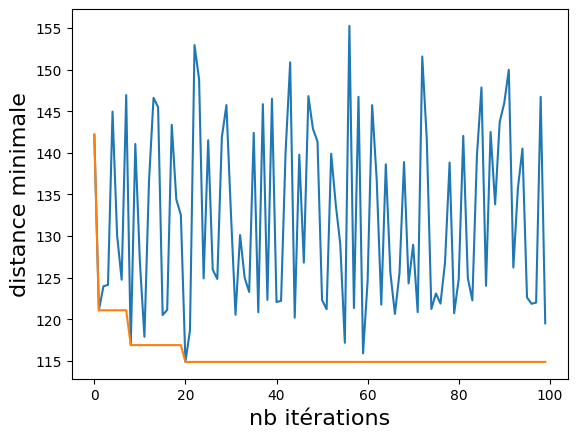

In [72]:
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("distance minimale", fontsize=16)
print(best_distances)
res = plt.plot(range(len(distances_list)), distances_list)
res = plt.plot(range(len(distances_list)),best_distances)

# Generation size impact on results

In [73]:

bornes = deque(())

nb_tests = 100
wanted_generations = 600
jump_size = 5
truck_num = 1

bar = IntProgress(min=10, max=600, layout={"width" : "100%"})
display(bar)

citiesTuple = read_csv_to_tuple(dataset_file_path)
citiesSample = sample_N_from_tuple(citiesTuple, 15)
print(citiesSample)
generator = create_location_generator(citiesSample)
distances_km = calculate_distance_matrix(generator)
distances_freq = generate_distances_frequency(distances_km)
trucks = split_into_trucks(distances_freq,truck_num)


distances_list = deque(())
best_distances = deque(())
borne = solve_issue(trucks)
for generation_size in range(10,nb_tests,jump_size):
    generator = create_location_generator(citiesSample)
    distances_km = calculate_distance_matrix(generator)
    distances_freq = generate_distances_frequency(distances_km)
    trucks = split_into_trucks(distances_freq,truck_num)
    start_point = next(iter(distances_km.keys()))
    paths_and_maps = multistart(max_threads,6,citiesSample,trucks,population_size,generation_size,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size)
    pathT = None
    mapT = None 
    sorted_list = sorted(paths_and_maps, key=lambda x: x[1])
    pathT, mapT = sorted_list[0][1],sorted_list[0][0]
    val = pathT
    best_distance_of_gen = val*100/borne      
    distances_list.append(best_distance_of_gen)    
    if len(best_distances) == 0 or best_distances[-1] > best_distance_of_gen:
        best_distances.append(best_distance_of_gen)
    else:
        best_distances.append(best_distances[-1])
                              
    bar.value += jump_size                                      

bar.close()

IntProgress(value=10, layout=Layout(width='100%'), max=600, min=10)

 the Function: read_csv_to_tuple took: 0.03089761734008789 seconds
 the Function: sample_N_from_tuple took: 0.008970499038696289 seconds
[['85252' '593' '46.641678701923' '-0.81661572115385'
  'Saint-Maurice-le-Girard']
 ['57166' '107' '48.889710701754' '6.5592729824561' 'Dalhain']
 ['21111' '317' '47.413132075472' '5.1689969811321' 'Brognon']
 ['40133' '6887' '43.600666769231' '-1.4232067692308' 'Labenne']
 ['55541' '525' '48.82490327044' '5.1978795597484' 'Vavincourt']
 ['14291' '289' '49.005706111111' '-0.38415083333333' 'Fresney-le-Vieux']
 ['40144' '244' '43.703818' '-0.73520413333333' 'Larbey']
 ['39326' '177' '46.595328448276' '5.6825704022989' 'Mesnois']
 ['12210' '454' '44.182297433628' '2.0195870353982'
  'Saint-André-de-Najac']
 ['15166' '314' '44.862371752266' '2.1913842296072' 'Roumégoux']
 ['54516' '17' '48.40278804878' '6.0543173170732' 'They-sous-Vaudemont']
 ['67443' '842' '48.9732466' '8.1451453' 'Scheibenhard']
 ['45169' '9482' '47.918088267717' '1.8235978740157' 'In

 the Function: genetic_algorithm took: 0.4932377338409424 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Fresney-le-Vieux', 'Ingré', 'Vavincourt', 'Dalhain', 'Carling', 'Scheibenhard', 'They-sous-Vaudemont', 'Gray', 'Brognon', 'Mesnois', 'Roumégoux', 'Saint-André-de-Najac', 'Labenne', 'Larbey', 'Saint-Maurice-le-Girard'] for a total of 58.9092695519708 h
 the Function: genetic_algorithm took: 0.5859806537628174 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Fresney-le-Vieux', 'Ingré', 'Vavincourt', 'Dalhain', 'Carling', 'Scheibenhard', 'They-sous-Vaudemont', 'Gray', 'Brognon', 'Mesnois', 'Roumégoux', 'Saint-André-de-Najac', 'Labenne', 'Larbey', 'Saint-Maurice-le-Girard'] for a total of 58.9092695519708 h
 the Function: genetic_algorithm took: 0.6327722072601318 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Labenne', 'Larbey', 'Saint-André-de-Najac', 'Roumégoux', 'Mesnois', 'Brognon', 'Gray', 'Scheibenhard', 'Carling', 'Dalhain', 'They-sous-Vau

 the Function: genetic_algorithm took: 0.39468836784362793 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Labenne', 'Larbey', 'Saint-André-de-Najac', 'Roumégoux', 'Mesnois', 'Brognon', 'Vavincourt', 'Scheibenhard', 'Carling', 'Dalhain', 'They-sous-Vaudemont', 'Gray', 'Ingré', 'Fresney-le-Vieux', 'Saint-Maurice-le-Girard'] for a total of 59.20792055328256 h
 the Function: genetic_algorithm took: 0.6147933006286621 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Roumégoux', 'Saint-André-de-Najac', 'Larbey', 'Labenne', 'Fresney-le-Vieux', 'Ingré', 'Mesnois', 'Gray', 'Brognon', 'Vavincourt', 'Scheibenhard', 'Carling', 'Dalhain', 'They-sous-Vaudemont', 'Saint-Maurice-le-Girard'] for a total of 65.69026042959658 h
 the Function: genetic_algorithm took: 0.8357226848602295 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Roumégoux', 'Saint-André-de-Najac', 'Larbey', 'Labenne', 'Fresney-le-Vieux', 'Ingré', 'Mesnois', 'Gray', 'Brognon', 'Vavincourt', 'Schei

 the Function: genetic_algorithm took: 1.4951605796813965 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Labenne', 'Larbey', 'Saint-André-de-Najac', 'Roumégoux', 'Mesnois', 'Brognon', 'Gray', 'They-sous-Vaudemont', 'Scheibenhard', 'Carling', 'Dalhain', 'Vavincourt', 'Ingré', 'Fresney-le-Vieux', 'Saint-Maurice-le-Girard'] for a total of 56.10565146412511 h
 the Function: genetic_algorithm took: 1.9303936958312988 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Labenne', 'Larbey', 'Saint-André-de-Najac', 'Roumégoux', 'Mesnois', 'Brognon', 'Gray', 'They-sous-Vaudemont', 'Scheibenhard', 'Carling', 'Dalhain', 'Vavincourt', 'Ingré', 'Fresney-le-Vieux', 'Saint-Maurice-le-Girard'] for a total of 56.10565146412511 h
 the Function: genetic_algorithm took: 1.9643054008483887 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Ingré', 'Fresney-le-Vieux', 'Carling', 'Scheibenhard', 'Dalhain', 'Vavincourt', 'They-sous-Vaudemont', 'Gray', 'Brognon', 'Mesnois', 'Rou

 the Function: genetic_algorithm took: 0.42822265625 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Fresney-le-Vieux', 'Ingré', 'Vavincourt', 'Carling', 'Scheibenhard', 'Dalhain', 'They-sous-Vaudemont', 'Brognon', 'Gray', 'Mesnois', 'Saint-André-de-Najac', 'Roumégoux', 'Larbey', 'Labenne', 'Saint-Maurice-le-Girard'] for a total of 59.1759325147678 h
 the Function: genetic_algorithm took: 0.5781130790710449 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Fresney-le-Vieux', 'Ingré', 'Vavincourt', 'Carling', 'Scheibenhard', 'Dalhain', 'They-sous-Vaudemont', 'Brognon', 'Gray', 'Mesnois', 'Saint-André-de-Najac', 'Roumégoux', 'Larbey', 'Labenne', 'Saint-Maurice-le-Girard'] for a total of 59.1759325147678 h
 the Function: genetic_algorithm took: 1.3435604572296143 seconds the Function: genetic_algorithm took: 1.4222972393035889 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Fresney-le-Vieux', 'Ingré', 'Carling', 'Scheibenhard', 'Dalhain', 'They-sous-Va

 the Function: genetic_algorithm took: 2.2250914573669434 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Labenne', 'Larbey', 'Saint-André-de-Najac', 'Roumégoux', 'Mesnois', 'Brognon', 'Gray', 'They-sous-Vaudemont', 'Scheibenhard', 'Carling', 'Dalhain', 'Vavincourt', 'Ingré', 'Fresney-le-Vieux', 'Saint-Maurice-le-Girard'] for a total of 52.965227979534376 h
 the Function: genetic_algorithm took: 3.1810271739959717 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Labenne', 'Larbey', 'Saint-André-de-Najac', 'Roumégoux', 'Mesnois', 'Brognon', 'Gray', 'Scheibenhard', 'Carling', 'Dalhain', 'They-sous-Vaudemont', 'Vavincourt', 'Ingré', 'Fresney-le-Vieux', 'Saint-Maurice-le-Girard'] for a total of 53.551626040460654 h
 the Function: genetic_algorithm took: 3.1919894218444824 seconds
The truck n: 0 will do: ['Saint-Maurice-le-Girard', 'Labenne', 'Larbey', 'Saint-André-de-Najac', 'Roumégoux', 'Mesnois', 'Brognon', 'Gray', 'They-sous-Vaudemont', 'Scheibenhard', 'Carling'

deque([176.46927487169458, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 168.1683500746041, 165.51633743604492, 165.51633743604492, 165.51633743604492, 165.51633743604492])


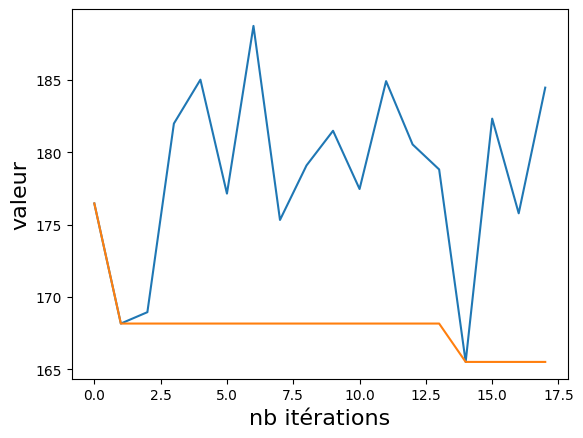

In [74]:
plt.xlabel("nb itérations", fontsize=16)
plt.ylabel("valeur", fontsize=16)
print(best_distances)
res = plt.plot(range(len(distances_list)), distances_list)
res = plt.plot(range(len(distances_list)),best_distances)

# Average results obtained

In [76]:

bornes = deque(())

nb_tests = 1000
wanted_generations = 100
jump_size = 5
truck_num = 1

bar = IntProgress(min=1, max=1000, layout={"width" : "100%"})
display(bar)

citiesTuple = read_csv_to_tuple(dataset_file_path)
citiesSample = sample_N_from_tuple(citiesTuple, 20)
print(citiesSample)
generator = create_location_generator(citiesSample)
distances_km = calculate_distance_matrix(generator)
distances_freq = generate_distances_frequency(distances_km)
trucks = split_into_trucks(distances_freq,truck_num)


distances_list = deque(())
borne = solve_issue(trucks)
for _ in range(1,nb_tests,jump_size):
    generator = create_location_generator(citiesSample)
    distances_km = calculate_distance_matrix(generator)
    distances_freq = generate_distances_frequency(distances_km)
    trucks = split_into_trucks(distances_freq,truck_num)
    start_point = next(iter(distances_km.keys()))
    paths_and_maps = multistart(max_threads,3,citiesSample,trucks,population_size,wanted_generations,mutation_rate,tournament_size,start_point,start_time,children_size,elite_size)
    pathT = None
    mapT = None 
    sorted_list = sorted(paths_and_maps, key=lambda x: x[1])
    pathT, mapT = sorted_list[0][1],sorted_list[0][0]
    val = pathT
    best_distance_of_gen = val*100/borne      
    distances_list.append(best_distance_of_gen)  
                              
    bar.value += jump_size                                      

bar.close()

IntProgress(value=1, layout=Layout(width='100%'), max=1000, min=1)

 the Function: read_csv_to_tuple took: 0.036876678466796875 seconds
 the Function: sample_N_from_tuple took: 0.011960029602050781 seconds
[['56036' '6920' '47.819236366279' '-3.3313725290698' 'Caudan']
 ['31542' '210' '43.051439589041' '0.57774575342466' 'Seilhan']
 ['28191' '2682' '48.601210780142' '1.6502685815603' 'Hanches']
 ['88475' '121' '48.096616036585' '5.7263040548781' 'Tollaincourt']
 ['2528' '228' '49.3323724' '3.07671136' 'Mortefontaine']
 ['34251' '519' '43.782883712121' '3.3848141666667'
  'Saint-Étienne-de-Gourgas']
 ['71153' '21269' '46.808665625' '4.425864375' 'Le Creusot']
 ['69021' '2340' '45.775115443038' '4.5487962658228' 'Bessenay']
 ['88255' '91' '48.455198607595' '5.7493083544304' 'Jubainville']
 ['71242' '521' '46.616739494382' '4.5477734831461' 'Joncy']
 ['18137' '505' '46.888689508197' '2.1730703278688' 'Mareuil-sur-Arnon']
 ['47210' '1846' '44.268837446809' '0.38364730496454' 'Port-Sainte-Marie']
 ['2293' '553' '49.93479125' '3.4516053676471' 'Étaves-et-Boc

 the Function: genetic_algorithm took: 1.4815630912780762 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Tresserve', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Hanches', 'Baulne', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 85.77283470354384 h
 the Function: genetic_algorithm took: 2.0591394901275635 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Caudan'] for a total of 84.99137079106775 h
 the Function: genetic_algorithm took: 2.3993778228759766 seconds


 the Function: genetic_algorithm took: 2.379692316055298 seconds the Function: genetic_algorithm took: 2.4011270999908447 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Hanches', 'Baulne', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 78.72699814184793 h

The truck n: 0 will do: ['Caudan', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Baulne', 'Hanches', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 77.60768901330613 h
 the Function: create_location_generator took: 0.0 seconds
 the Fun

 the Function: genetic_algorithm took: 1.02223539352417 seconds
The truck n: 0 will do: ['Caudan', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 78.66881870371172 h
 the Function: genetic_algorithm took: 2.4186251163482666 seconds
The truck n: 0 will do: ['Caudan', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Tresserve', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Caudan'] for a total of 84.23738222109252 h
 the Function: genetic_algorithm took: 2.491377830505371 seconds
The

 the Function: genetic_algorithm took: 2.4044554233551025 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Tresserve', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Baulne', 'Hanches', 'Caudan'] for a total of 81.09928205784627 h
 the Function: genetic_algorithm took: 2.4303689002990723 seconds
The truck n: 0 will do: ['Caudan', 'Baulne', 'Mortefontaine', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Étaves-et-Bocquiaux', 'Zudausques', 'Hanches', 'Caudan'] for a total of 85.84319945733074 h
 the Function: create_location_generator took: 0.0 seconds
 the Fu

 the Function: genetic_algorithm took: 2.3368453979492188 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Baulne', 'Hanches', 'Caudan'] for a total of 72.02990633012337 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.031893014907836914 seconds
 the Function: generate_distances_frequency took: 0.0009968280792236328 seconds
 the Function: genetic_algorithm took: 0.8762705326080322 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur

 the Function: genetic_algorithm took: 0.9113020896911621 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Caudan'] for a total of 77.44701187455081 h
 the Function: genetic_algorithm took: 2.243068218231201 seconds
The truck n: 0 will do: ['Caudan', 'Mortefontaine', 'Zudausques', 'Étaves-et-Bocquiaux', 'Jubainville', 'Berentzwiller', 'Tollaincourt', 'Sainte-Colombe-en-Auxois', 'Joncy', 'Le Creusot', 'Hanches', 'Baulne', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Port-Sainte-Marie', 'Seilhan', 'Caudan'] for a total of 88.50156246049877 h
 the Function: genetic_algorithm took: 2.370640993118286 seconds
Th

 the Function: genetic_algorithm took: 1.7723026275634766 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Baulne', 'Hanches', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Port-Sainte-Marie', 'Seilhan', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 78.88887675340149 h
 the Function: genetic_algorithm took: 2.030000686645508 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 74.50493648298897 h
 the Function: create_location_generator took: 0.0 seconds
 the Fun

 the Function: genetic_algorithm took: 2.4825685024261475 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', 'Bessenay', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Baulne', 'Hanches', 'Mortefontaine', 'Zudausques', 'Étaves-et-Bocquiaux', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Joncy', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Port-Sainte-Marie', 'Seilhan', "Le Mas-d'Artige", 'Caudan'] for a total of 87.369115110892 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.03189253807067871 seconds
 the Function: generate_distances_frequency took: 0.0019936561584472656 seconds
 the Function: genetic_algorithm took: 0.8877272605895996 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Hanches', 'Baulne', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Tresserve', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Mareuil-sur-Arnon', "Le Mas-d'Ar

 the Function: genetic_algorithm took: 1.0247795581817627 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Le Creusot', 'Joncy', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Sainte-Colombe-en-Auxois', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 80.83490323172887 h
 the Function: genetic_algorithm took: 2.490800619125366 seconds the Function: genetic_algorithm took: 2.490800142288208 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Baulne', 'Hanches', 'Caudan'] for a total of 76.6342534833728 h

The

 the Function: genetic_algorithm took: 2.117570400238037 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Port-Sainte-Marie', 'Seilhan', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 77.0735394620966 h
 the Function: genetic_algorithm took: 2.229494333267212 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Mortefontaine', 'Zudausques', 'Étaves-et-Bocquiaux', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Port-Sainte-Marie', 'Seilhan', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 76.35546349104021 h
 the Function: create_location_generator took: 0.0 seconds
 the Funct

 the Function: genetic_algorithm took: 1.528435230255127 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Baulne', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 78.74591283288797 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.028902769088745117 seconds
 the Function: generate_distances_frequency took: 0.001993417739868164 seconds
 the Function: genetic_algorithm took: 0.99623703956604 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', "Le Mas-d'Artige", 'Tresserve', 'Mollans-sur-Ouvèze', 'Bessenay', 'Joncy', 'Le Creusot', 'Berentzwiller', 'Jubainville', 'Tollaincourt', 'Sainte-Colombe-en-Auxoi

 the Function: genetic_algorithm took: 0.8123822212219238 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Tresserve', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 74.88153401287032 h
 the Function: genetic_algorithm took: 1.6308932304382324 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', 'Baulne', 'Hanches', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', "Le Mas-d'Artige", 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 81.83790263944269 h
 the Function: genetic_algorithm took: 1.562347173690796 seconds
T

 the Function: genetic_algorithm took: 1.8897688388824463 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Mareuil-sur-Arnon', 'Baulne', 'Hanches', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Caudan'] for a total of 85.36451863815977 h
 the Function: genetic_algorithm took: 1.591935157775879 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Hanches', 'Baulne', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Bessenay', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 84.42412266656883 h
 the Function: create_location_generator took: 0.0 seconds
 the Fun

 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.029900074005126953 seconds
 the Function: generate_distances_frequency took: 0.0019931793212890625 seconds
 the Function: genetic_algorithm took: 0.8873672485351562 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Hanches', 'Baulne', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Tresserve', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Le Creusot', 'Joncy', 'Sainte-Colombe-en-Auxois', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Caudan'] for a total of 84.0150603846281 h
 the Function: genetic_algorithm took: 2.0613861083984375 seconds
The truck n: 0 will do: ['Caudan', 'Seilhan', 'Port-Sainte-Marie', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Joncy', 'Le Creusot', 'Tresserve', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mo

 the Function: genetic_algorithm took: 0.8038532733917236 seconds
The truck n: 0 will do: ['Caudan', 'Mortefontaine', 'Hanches', 'Baulne', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Caudan'] for a total of 77.5563827303864 h
 the Function: genetic_algorithm took: 2.0465996265411377 seconds
The truck n: 0 will do: ['Caudan', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Sainte-Colombe-en-Auxois', 'Jubainville', 'Tollaincourt', 'Tresserve', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Joncy', 'Le Creusot', 'Berentzwiller', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 89.06565579883089 h
 the Function: genetic_algorithm took: 2.2589454650878906 seconds
T

 the Function: genetic_algorithm took: 1.961575984954834 seconds
The truck n: 0 will do: ['Caudan', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Berentzwiller', 'Jubainville', 'Tollaincourt', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Mareuil-sur-Arnon', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Caudan'] for a total of 77.67327590306245 h
 the Function: genetic_algorithm took: 1.95473051071167 seconds
The truck n: 0 will do: ['Caudan', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Joncy', 'Le Creusot', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Jubainville', 'Tresserve', 'Bessenay', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 89.96099751238694 h
 the Function: create_location_generator took: 0.0 seconds
 the Funct

 the Function: genetic_algorithm took: 0.9005050659179688 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Jubainville', 'Tollaincourt', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Caudan'] for a total of 75.76995256013376 h
 the Function: genetic_algorithm took: 2.225445032119751 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', "Le Mas-d'Artige", 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 80.88881557800245 h
 the Function: genetic_algorithm took: 2.3779354095458984 seconds
T

 the Function: genetic_algorithm took: 2.4506702423095703 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 83.91561254943839 h
 the Function: genetic_algorithm took: 2.493525981903076 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 76.23782263009633 h
 the Function: create_location_generator took: 0.0 seconds
 the Fun

 the Function: genetic_algorithm took: 2.5244672298431396 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Tresserve', 'Le Creusot', 'Joncy', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Berentzwiller', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Caudan'] for a total of 79.53931451355815 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.03189492225646973 seconds
 the Function: generate_distances_frequency took: 0.0019931793212890625 seconds
 the Function: genetic_algorithm took: 0.9744458198547363 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze

 the Function: genetic_algorithm took: 1.0787663459777832 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 78.01357253938696 h
 the Function: genetic_algorithm took: 2.4950907230377197 seconds
The truck n: 0 will do: ['Caudan', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Berentzwiller', 'Jubainville', 'Tollaincourt', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Mareuil-sur-Arnon', 'Baulne', 'Hanches', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Caudan'] for a total of 80.75465173031472 h
 the Function: genetic_algorithm took: 2.5339741706848145 seconds


 the Function: genetic_algorithm took: 2.4048869609832764 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Jubainville', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Berentzwiller', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Bessenay', 'Joncy', 'Le Creusot', 'Mareuil-sur-Arnon', 'Caudan'] for a total of 83.61476570203214 h
 the Function: genetic_algorithm took: 2.475984573364258 seconds
The truck n: 0 will do: ['Caudan', 'Seilhan', 'Port-Sainte-Marie', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Caudan'] for a total of 80.33708465412472 h
 the Function: create_location_generator took: 0.0 seconds
 the Fun

 the Function: genetic_algorithm took: 0.9228739738464355 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', 'Le Creusot', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Hanches', 'Baulne', 'Sainte-Colombe-en-Auxois', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Caudan'] for a total of 83.77302266536324 h
 the Function: genetic_algorithm took: 2.336024045944214 seconds the Function: genetic_algorithm took: 2.3559584617614746 seconds
The truck n: 0 will do: ['Caudan', 'Baulne', 'Hanches', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Tresserve', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Caudan'] for a total of 84.4925075784642 h

Th

 the Function: genetic_algorithm took: 2.458056688308716 seconds the Function: genetic_algorithm took: 2.4610469341278076 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Baulne', 'Hanches', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Le Creusot', 'Caudan'] for a total of 83.78697584591089 h

The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Hanches', 'Baulne', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 78.56916921805306 h
 the Function: create_location_generator took: 0.0 seconds
 the Fun

 the Function: genetic_algorithm took: 0.9441201686859131 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Baulne', 'Hanches', 'Caudan'] for a total of 81.63878408243177 h
 the Function: genetic_algorithm took: 2.385141134262085 seconds
The truck n: 0 will do: ['Caudan', 'Mortefontaine', 'Baulne', 'Hanches', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Caudan'] for a total of 80.73785860444933 h
 the Function: genetic_algorithm took: 2.387134552001953 seconds
Th

 the Function: genetic_algorithm took: 2.2445945739746094 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 77.74479050307099 h
 the Function: genetic_algorithm took: 2.3713505268096924 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Hanches', 'Baulne', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Caudan'] for a total of 81.26145390463674 h
 the Function: create_location_generator took: 0.0 seconds
 the Fu

 the Function: genetic_algorithm took: 0.8566927909851074 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Hanches', 'Baulne', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Joncy', 'Le Creusot', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Caudan'] for a total of 83.16864364062282 h
 the Function: genetic_algorithm took: 2.2815306186676025 seconds the Function: genetic_algorithm took: 2.2855234146118164 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', "Le Mas-d'Artige", 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 79.17366676702866 h



 the Function: genetic_algorithm took: 2.284454107284546 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 75.0008508144468 h
 the Function: genetic_algorithm took: 2.3123607635498047 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 75.0008508144468 h
 the Function: create_location_generator took: 0.0 seconds
 the Funct

 the Function: genetic_algorithm took: 0.9332146644592285 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', "Le Mas-d'Artige", 'Bessenay', 'Tresserve', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Jubainville', 'Tollaincourt', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Hanches', 'Baulne', 'Mareuil-sur-Arnon', 'Caudan'] for a total of 83.16105111456594 h
 the Function: genetic_algorithm took: 2.3463830947875977 seconds the Function: genetic_algorithm took: 2.375286340713501 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Bessenay', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Baulne', 'Hanches', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Joncy', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Caudan'] for a total of 88.08821014463317 h

T

 the Function: genetic_algorithm took: 2.4385225772857666 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Sainte-Colombe-en-Auxois', 'Baulne', 'Hanches', 'Caudan'] for a total of 84.99689851888914 h
 the Function: genetic_algorithm took: 2.461446762084961 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Baulne', 'Hanches', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 83.16459500213429 h
 the Function: create_location_generator took: 0.0 seconds
 the Fun

 the Function: genetic_algorithm took: 0.8461112976074219 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 82.99455000834183 h
 the Function: genetic_algorithm took: 2.276970624923706 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Mareuil-sur-Arnon', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', "Le Mas-d'Artige", 'Bessenay', 'Mollans-sur-Ouvèze', 'Tresserve', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Berentzwiller', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Caudan'] for a total of 89.50245656870145 h
 the Function: genetic_algorithm took: 2.3048741817474365 seconds
T

 the Function: genetic_algorithm took: 2.3182644844055176 seconds
The truck n: 0 will do: ['Caudan', 'Baulne', 'Hanches', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Mortefontaine', 'Zudausques', 'Étaves-et-Bocquiaux', 'Jubainville', 'Berentzwiller', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 81.53541573281728 h
 the Function: genetic_algorithm took: 2.3885247707366943 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Berentzwiller', 'Jubainville', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Baulne', 'Hanches', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Caudan'] for a total of 77.63471556468818 h
 the Function: create_location_generator took: 0.0 seconds
 the Fu

 the Function: genetic_algorithm took: 1.5110769271850586 seconds
The truck n: 0 will do: ['Caudan', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Hanches', 'Baulne', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Tresserve', 'Bessenay', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 80.43924018428903 h
 the Function: create_location_generator took: 0.0 seconds
 the Function: calculate_distance_matrix took: 0.03089618682861328 seconds
 the Function: generate_distances_frequency took: 0.0019936561584472656 seconds
 the Function: genetic_algorithm took: 0.9807143211364746 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Mortefontaine', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Le Creusot', 'Joncy', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-

 the Function: genetic_algorithm took: 0.9424664974212646 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Baulne', 'Hanches', 'Caudan'] for a total of 75.07489240943404 h
 the Function: genetic_algorithm took: 2.3197195529937744 seconds the Function: genetic_algorithm took: 2.3740932941436768 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Baulne', 'Hanches', 'Caudan'] for a total of 75.07489240943404 h



 the Function: genetic_algorithm took: 1.9069838523864746 seconds
The truck n: 0 will do: ['Caudan', 'Bessenay', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 82.94718131426328 h
 the Function: genetic_algorithm took: 2.3851675987243652 seconds
The truck n: 0 will do: ['Caudan', 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Berentzwiller', 'Tollaincourt', 'Jubainville', 'Étaves-et-Bocquiaux', 'Zudausques', 'Mortefontaine', 'Baulne', 'Hanches', 'Caudan'] for a total of 76.26538423207323 h
 the Function: create_location_generator took: 0.0 seconds
 the Fu

 the Function: genetic_algorithm took: 1.02244234085083 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Mareuil-sur-Arnon', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Jubainville', 'Berentzwiller', 'Tresserve', 'Bessenay', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Caudan'] for a total of 81.62606301654466 h
 the Function: genetic_algorithm took: 2.349823236465454 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Baulne', 'Zudausques', 'Étaves-et-Bocquiaux', 'Mortefontaine', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Tresserve', 'Caudan'] for a total of 84.48015748315713 h
 the Function: genetic_algorithm took: 2.484060287475586 seconds
The 

 the Function: genetic_algorithm took: 2.2645084857940674 seconds
The truck n: 0 will do: ['Caudan', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Tresserve', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Tollaincourt', 'Berentzwiller', 'Jubainville', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Hanches', 'Baulne', 'Caudan'] for a total of 76.56573147709621 h
 the Function: genetic_algorithm took: 2.348266839981079 seconds
The truck n: 0 will do: ['Caudan', "Le Mas-d'Artige", 'Mareuil-sur-Arnon', 'Baulne', 'Hanches', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Bessenay', 'Tresserve', 'Mollans-sur-Ouvèze', 'Saint-Étienne-de-Gourgas', 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 77.04667156876278 h
 the Function: create_location_generator took: 0.0 seconds
 the Fun

 the Function: genetic_algorithm took: 0.8579323291778564 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Tresserve', 'Saint-Étienne-de-Gourgas', 'Mollans-sur-Ouvèze', 'Bessenay', 'Joncy', 'Le Creusot', 'Sainte-Colombe-en-Auxois', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Seilhan', 'Port-Sainte-Marie', 'Caudan'] for a total of 85.03341770644988 h
 the Function: genetic_algorithm took: 1.8421697616577148 seconds
The truck n: 0 will do: ['Caudan', 'Hanches', 'Baulne', 'Mortefontaine', 'Étaves-et-Bocquiaux', 'Zudausques', 'Jubainville', 'Tollaincourt', 'Berentzwiller', 'Sainte-Colombe-en-Auxois', 'Le Creusot', 'Joncy', 'Tresserve', 'Mollans-sur-Ouvèze', 'Bessenay', 'Mareuil-sur-Arnon', "Le Mas-d'Artige", 'Port-Sainte-Marie', 'Seilhan', 'Saint-Étienne-de-Gourgas', 'Caudan'] for a total of 83.69619834284724 h
 the Function: genetic_algorithm took: 2.3148536682128906 seconds


Text(0.5, 1.0, 'Distribution des distances à la borne inférieure')

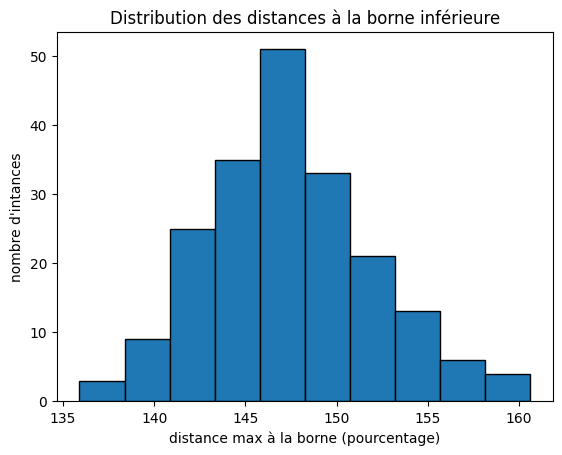

In [77]:
plt.hist(distances_list, edgecolor = "black")                         
plt.xlabel("distance max à la borne (pourcentage)")               
plt.ylabel("nombre d'intances")                               
plt.title("Distribution des distances à la borne inférieure") 

In [78]:
print("median={:.2f}".format(statistics.median(distances_list))) 
print("average={:.2f}, standard deviation={:.2f}".format(         
      statistics.fmean(distances_list),np.std(distances_list)))           

median=147.00
average=147.39, standard deviation=4.62
